In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus, RectangularAperture
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    #plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [3]:
run_all = True  # set to False to run only the first epoch
#cluster = 'PAL5'
#cluster = 'PAL13'
cluster = 'IC4499'
base_dir = 'data/'+cluster+'/'
#channel = '3p6um'
channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
#sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]
    
if cluster == 'IC4499':
    default_list = list(range(98))
    ch1_notlist = [25, 32, 37, 40, 42, 43, 51, 58, 67, 72, 77, 87, 94]  # stars NOT in each channel
    ch2_notlist = [21, 25, 32, 37, 40, 42, 51, 58, 67, 69, 72, 77, 87]  # (way too long the other way lol)
    ch1_list = [i for i in default_list if i not in ch1_notlist]
    ch2_list = [j for j in default_list if j not in ch2_notlist]

if channel == '3p6um':
    zmag       = 18.80           # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02           # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233         # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  apcorr * 0.02  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  apcorr * 0.02
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

Current star: RRL1
Star's pixel coordinates: (269.27574718974904, 272.6638949845443)

i am in de mask


Current star: RRL2
Star's pixel coordinates: (415.4158001587801, 183.80143425453736)


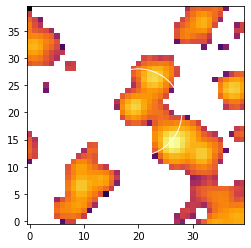

Number of PSF stars: 5


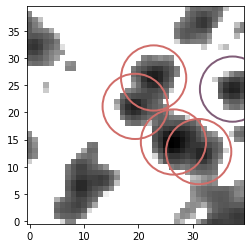

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08536739999999998s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
31.091956 12.780353 6129.7181   1 ... 426.50776 176.58179 225.13677 -82.242348
26.450472 14.546096 6904.3115   2 ... 421.86627 178.34753 225.14006 -82.241649
19.409205 21.098171 2956.0081   3 ...   414.825 184.89961 225.14219 -82.240072
22.805328 26.324778 3214.9506   5 ... 418.22113 190.12621 225.13497 -82.239713
37.316489 24.277569 1559.7534   4 ... 432.73229   188.079 225.12212 -82.241432



Current star: RRL3
Star's pixel coordinates: (606.7275837472373, 295.5581500090886)


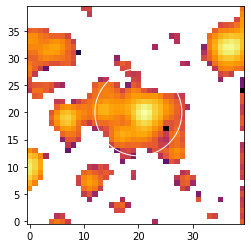

Number of PSF stars: 3


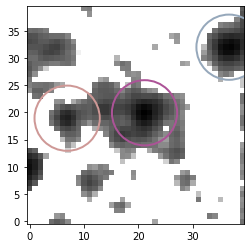

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05050360000000076s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.8932984 18.923736 668.52727   1 ... 593.62088 294.48189 224.88431 -82.243179
21.133907 19.921693 2314.2704   2 ... 607.86149 295.47984 224.86943 -82.244456
36.673297 31.986234 1709.4515   3 ... 623.40088 307.54438 224.84514 -82.244377



Current star: RRL4
Star's pixel coordinates: (416.1836082401056, 406.4392677029107)

i am in de mask


Current star: RRL5
Star's pixel coordinates: (478.2457806893284, 324.6495021361123)

i am in de mask


Current star: RRL6
Star's pixel coordinates: (353.99956143536497, 403.6452858596207)

i am in de mask


Current star: RRL7
Star's pixel coordinates: (159.1340723481958, 617.4171353014702)


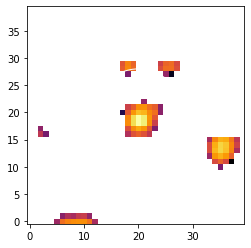

Number of PSF stars: 3


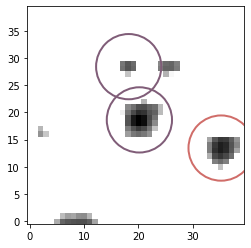

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.14554839999999913s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.216761 13.432295 1539.2678   1 ... 174.35083 610.84943 225.06642 -82.159198
20.184287 18.615406  2430.742   2 ... 159.31836 616.03254 225.07737 -82.157009
18.219528 28.408981 490.72822   3 ...  157.3536 625.82612 225.07215 -82.155504
25.495328 28.303207 452.66884   1 ...  164.6294 625.72034  225.0651 -82.156242



Current star: RRL8
Star's pixel coordinates: (169.94329105573536, 408.5746286949959)


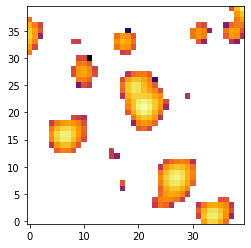

Number of PSF stars: 4


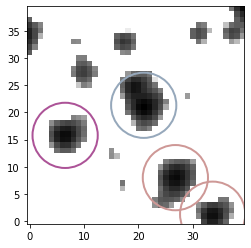

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07651939999999868s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 33.66249 1.2620206 1081.0224   1 ... 183.60578 389.83665 225.21914 -82.189643
 26.80573 7.9892042 2097.7774   2 ... 176.74902 396.56383 225.22093  -82.18806
 6.523621 15.767568 1621.3481   3 ... 156.46691  404.3422 225.23513 -82.184997
20.978914 21.301809 3010.0755   4 ... 170.92221 409.87644 225.21687 -82.185702
19.280125 24.914951 864.83537   1 ... 169.22342 413.48958 225.21589  -82.18505



Current star: RRL9
Star's pixel coordinates: (184.69905049419538, 435.2179715349312)


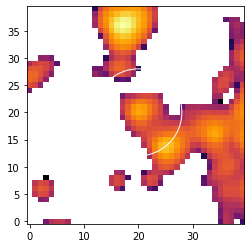

Number of PSF stars: 4


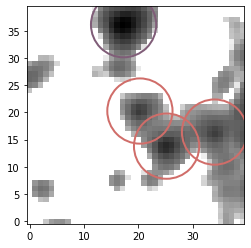

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07140790000000052s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
25.187222 13.783632 5766.7239   1 ... 189.88627  429.0016 225.18422 -82.185042
34.008376 16.374615   5274.16   2 ... 198.70743 431.59259 225.17366 -82.185576
20.280491 20.243875 3356.6969   3 ... 184.97954 435.46185  225.1843  -82.18369
17.276012 36.123662 20009.477   4 ... 181.97506 451.34163  225.1756  -82.18127



Current star: RRL10
Star's pixel coordinates: (305.058048336237, 440.56455390718247)

i am in de mask


Current star: RRL11
Star's pixel coordinates: (278.2836611011982, 227.98314362721047)


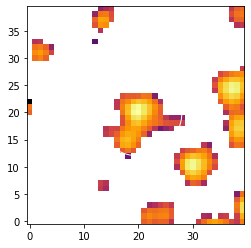

Number of PSF stars: 3


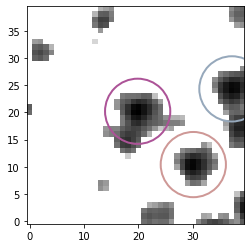

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.09829240000000006s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.103991 10.392879 2077.4697   1 ... 288.38765 218.37602 225.24234 -82.222986
19.865563 20.194264 3016.1451   2 ... 278.14922 228.17741  225.2452 -82.220655
37.204723 24.321747 2203.3577   3 ... 295.48838 232.30489 225.22506 -82.221836
17.890567 14.901316 839.35636   1 ... 276.17423 222.88446 225.25105 -82.221164



Current star: RRL12
Star's pixel coordinates: (169.9463278097029, 337.57071298030576)


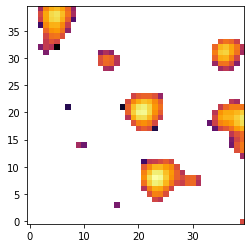

Number of PSF stars: 5


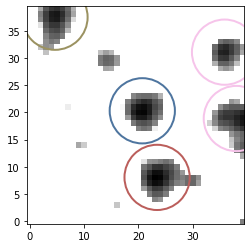

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.078273900000001s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
23.441261 8.0363472 2381.6684   1 ... 173.38759 325.60706 225.27643 -82.197189
38.017513 18.868333 1463.4292   2 ... 187.96384 336.43905 225.25414 -82.197202
35.849708 31.074589 983.50735   4 ... 185.79604  348.6453 225.24728 -82.195357
 20.71812  20.28806 2101.6139   3 ... 170.66445 337.85877 225.27008 -82.195283
4.6593648 37.502392 1480.2943   5 ... 154.60569 355.07311 225.27318 -82.191382



Current star: RRL13
Star's pixel coordinates: (337.7026048765051, 290.0922923814303)

i am in de mask


Current star: RRL14
Star's pixel coordinates: (366.85724421913886, 307.6730555307199)

i am in de mask


Current star: RRL15
Star's pixel coordinates: (400.2480094535217, 350.18160459389014)

i am in de mask


Current star: RRL16
Star's pixel coordinates: (424.7607661558434, 489.747328992378

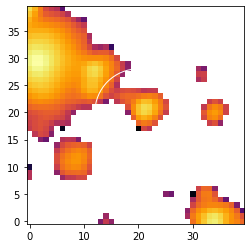

Number of PSF stars: 3


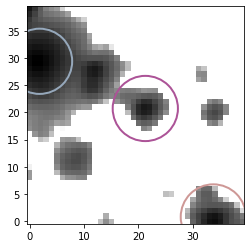

Time taken to fit PSF model: 0.09682740000000045s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
33.787675  0.759746 2884.7599   1 ... 438.54844 470.50707 224.90894 -82.204222
21.272912 20.712856 2392.2229   2 ... 426.03368 490.46019 224.90672 -82.200308
1.8192321   29.3934 11764.699   3 ...    406.58 499.14073 224.91958 -82.197217
11.674724 27.342621 4982.5013   1 ... 416.43549 497.08995 224.91135 -82.198469



Current star: RRL17
Star's pixel coordinates: (395.8376481113387, 403.3777361227561)

i am in de mask


Current star: RRL18
Star's pixel coordinates: (489.55596917216167, 381.9867653130465)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


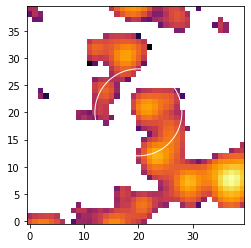

Number of PSF stars: 5


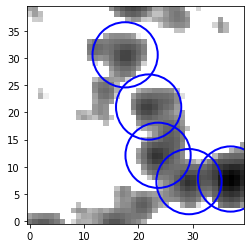

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08475770000000082s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.306964 7.2570504 5524.5375   1 ... 498.86293 369.24382 224.92342 -82.223769
36.950723 7.7385007  16288.43   2 ... 506.50669 369.72527  224.9155 -82.224462
23.619558 12.103942 3749.2526   3 ... 493.17553 374.09071  224.9255 -82.222556
21.882895 20.978751 2483.3586   4 ... 491.43886 382.96552 224.92071 -82.221195
17.560013 30.583435  2411.396   5 ... 487.11598  392.5702 224.91795 -82.219479



Current star: RRL19
Star's pixel coordinates: (624.9152174721671, 473.5524582808641)


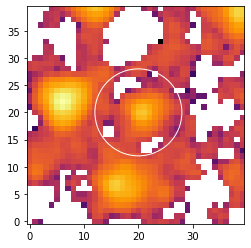

Number of PSF stars: 5


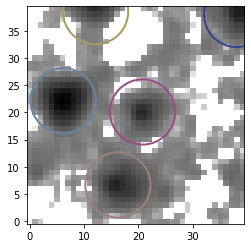

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07083350000000088s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
16.239635 6.6359214 3510.1176   1 ... 621.15485 460.18838 224.73569 -82.223673
20.773086 20.072647 1968.9654   2 ...  625.6883 473.62511 224.72139 -82.222317
6.1813001 22.119077 11421.127   3 ... 611.09652 475.67154 224.73437 -82.220601
12.127161  38.53635 911.96539   4 ... 617.04238 492.08881  224.7165 -82.218983
38.071148 38.020895 2029.5519   5 ... 642.98637 491.57335 224.69113 -82.221612



Current star: RRL20
Star's pixel coordinates: (267.4226597516115, 595.9430294257124)


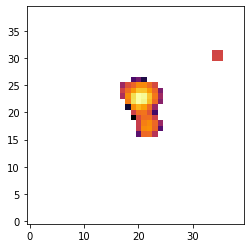

Number of PSF stars: 4


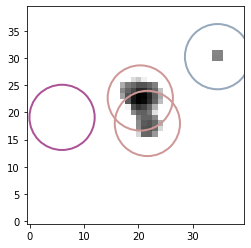

Time taken to fit PSF model: 0.06381709999999963s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.654205  17.95764 2710.9808   1 ... 269.07686 593.90067 224.98582 -82.170882
20.347741 22.643087 3256.2579   3 ...  267.7704 598.58612 224.98369 -82.170125
5.9576996 19.080063 257.83977   2 ... 253.38036 595.02309 225.00042 -82.169173
 34.56031 30.248019 362.12897   4 ... 281.98297 606.19105 224.96418 -82.170518



Current star: RRL21
Star's pixel coordinates: (129.62025760092808, 478.31632180786846)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


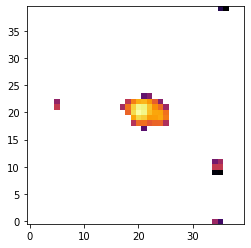

Number of PSF stars: 1


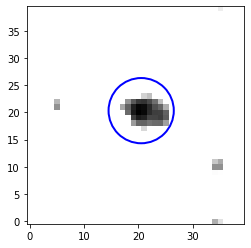

Time taken to fit PSF model: 0.046795300000001205s
   x_0       y_0      flux_0   id ...  x_true    y_true      RA       dec    
--------- --------- --------- --- ... -------- --------- --------- ----------
20.513042 20.315635 2302.4702   1 ... 130.1333 478.63196 225.20643 -82.172454



Current star: RRL23
Star's pixel coordinates: (288.7089913340642, 217.67570763290908)


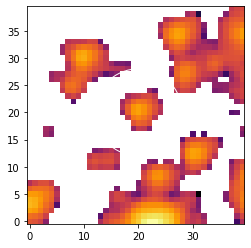

Number of PSF stars: 5


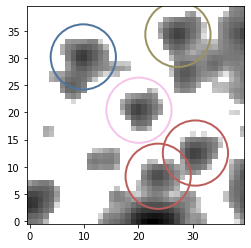

Time taken to fit PSF model: 0.07252979999999987s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
23.637281 8.2427224 2366.6505   1 ... 292.34627 205.91843 225.24764 -82.225043
30.490765 12.515443 2137.2178   2 ... 299.19976 210.19115 225.23772 -82.225158
20.103991 20.392879 1822.4998   3 ... 288.81298 218.06859 225.24215 -82.223069
 9.865563 30.194264 2761.1752   4 ... 278.57455 227.86997 225.24501 -82.220739
27.272296 34.336296 2435.4323   5 ... 295.98129   232.012 225.22479 -82.221925



Current star: RRL24
Star's pixel coordinates: (461.4970441172251, 344.3896586598582)

i am in de mask


Current star: RRL25
Star's pixel coordinates: (551.5926978375926, 456.4153452499181)


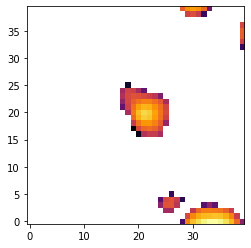

Number of PSF stars: 1


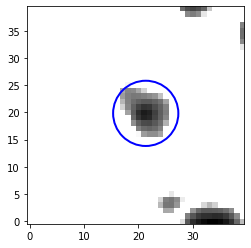

Time taken to fit PSF model: 0.03982850000000049s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.350576 19.816748 3100.5435   1 ... 552.94327 456.23209 224.80621 -82.217464



Current star: RRL27
Star's pixel coordinates: (252.89378402679029, 491.0760582680191)


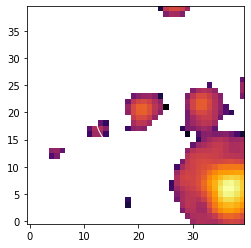

Number of PSF stars: 3


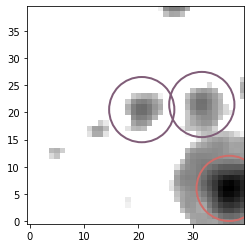

Time taken to fit PSF model: 0.05132509999999968s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.693646 6.0149273 83464.702   1 ... 269.58743 477.09099 225.07066 -82.186559
20.617477 20.503115 2241.3406   2 ... 253.51126 491.57917 225.07586 -82.183022
31.667467 21.442719  2610.336   3 ... 264.56125 492.51878 225.06431 -82.183996



Current star: RRL28
Star's pixel coordinates: (440.01268976990343, 303.9422655888487)

i am in de mask


Current star: RRL29
Star's pixel coordinates: (336.42903552565343, 297.45978181433713)

i am in de mask


Current star: RRL30
Star's pixel coordinates: (296.8021209131504, 231.64647114645464)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


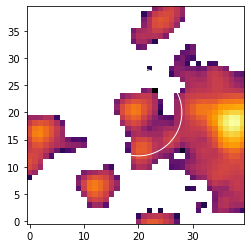

Number of PSF stars: 4


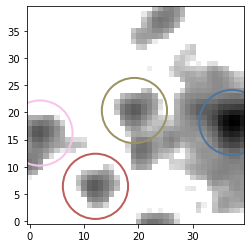

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0896220999999997s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
12.103991 6.3928793 1823.6938   1 ... 288.90611 218.03935 225.24208 -82.223082
1.8908911 16.190375 2488.6478   2 ... 278.69301 227.83685 225.24491 -82.220755
37.210505 18.138098 40449.413   3 ... 314.01263 229.78457 225.20865 -82.224023
19.272296 20.336296 2452.8209   4 ... 296.07442 231.98277 225.22472 -82.221938
31.275027  20.41699 3267.6436   1 ... 308.07715 232.06346 225.21282 -82.223126



Current star: RRL31
Star's pixel coordinates: (246.3816734805099, 454.012517887892)

i am in de mask


Current star: RRL32
Star's pixel coordinates: (286.01503053559094, 267.0791386642338)

i am in de mask


Current star: RRL34
Star's pixel coordinates: (376.55938767296993, 103.35711198880452)


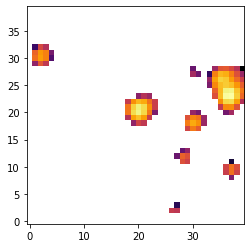

Number of PSF stars: 4


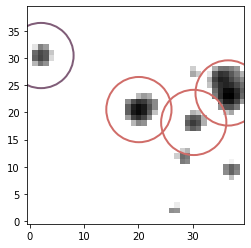

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07708069999999978s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.182401 18.146159 1250.2766   1 ... 386.74179 101.50327 225.23164 -82.248403
20.095184 20.510622 1850.3266   2 ... 376.65457 103.86773 225.23986  -82.24708
36.502249 23.569334 3025.3394   3 ... 393.06164 106.92645 225.22137 -82.248311
2.0825423 30.454561  707.6354   4 ... 358.64193 113.81167 225.25031 -82.243954
37.122535 9.4428597 542.64814   1 ... 393.68192 92.799972 225.23122 -82.250258
35.083922 26.857386 1031.8227   2 ... 391.64331  110.2145 225.22034 -82.247731



Current star: RRL35
Star's pixel coordinates: (154.94846209079844, 217.08332140270946)


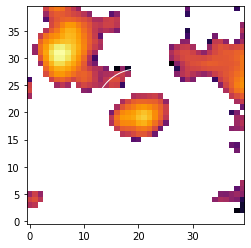

Number of PSF stars: 2


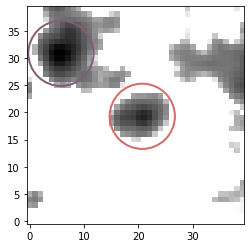

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06180649999999943s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.713972 19.276477 3138.9969   1 ... 155.66243  216.3598 225.37446 -82.209973
5.7535653 30.856831 10300.559   2 ... 140.70203 227.94015 225.38059 -82.206932
17.067181 18.861792 509.49803   1 ... 152.01564 215.94511 225.37835 -82.209663
7.4705152 35.188353 1387.1866   2 ... 142.41898 232.27167 225.37571 -82.206527



Current star: RRL36
Star's pixel coordinates: (415.1715451594607, 260.5341837538059)

i am in de mask


Current star: RRL37
Star's pixel coordinates: (451.3038176788455, 509.37365001989616)


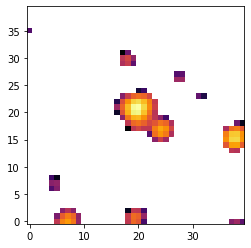

Number of PSF stars: 5


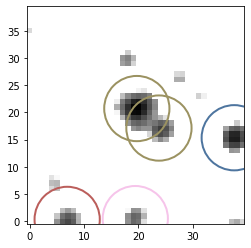

Time taken to fit PSF model: 0.06051099999999998s
   x_0       y_0       flux_0   id ...   x_true    y_true      RA       dec    
--------- ---------- --------- --- ... --------- --------- --------- ----------
6.8980895 0.31036436 755.07077   1 ... 438.20191 489.68401 224.89527 -82.201619
19.431635 0.45477321 540.56301   2 ... 450.73545 489.82842 224.88279 -82.202841
37.632126  15.330989 1131.9095   3 ... 468.93594 504.70464 224.85395  -82.20265
23.782161   17.11384 2351.0029   4 ... 455.08598 506.48749 224.86633 -82.201039
19.712314  20.700271 2975.1264   5 ... 451.01613 510.07392 224.86773 -82.200155



Current star: RRL39
Star's pixel coordinates: (163.99605382852974, 568.8763062466728)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


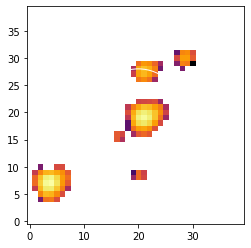

Number of PSF stars: 4


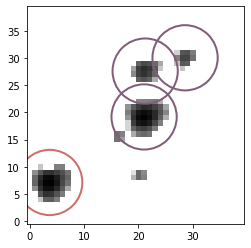

Time taken to fit PSF model: 0.15622019999999992s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
3.6943345 7.1057506 2509.4553   1 ... 147.69039 555.98206 225.13261 -82.163876
21.049951 19.158798 2600.4306   2 ...   165.046  568.0351 225.10679 -82.163995
21.247277 27.594131 1128.7138   3 ... 165.24333 576.47044 225.10044 -82.162887
28.589799 30.037364 725.17968   4 ... 172.58585 578.91367 225.09146 -82.163292



Current star: RRL40
Star's pixel coordinates: (246.16457252595, 215.98867784704058)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


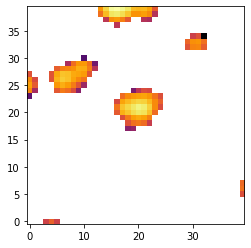

Number of PSF stars: 2


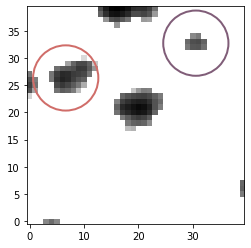

Time taken to fit PSF model: 0.06577840000000101s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.6310397  26.32991 1850.4248   1 ... 232.79561 222.31859  225.2942 -82.216902
30.569191 32.729552 649.48284   2 ... 256.73376 228.71823  225.2659 -82.218443
10.171691 28.321775 618.59167   1 ... 236.33626 224.31045 225.28924 -82.216991



Current star: RRL42
Star's pixel coordinates: (415.47273252101144, 496.7655085177343)


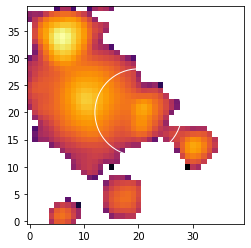

Number of PSF stars: 2


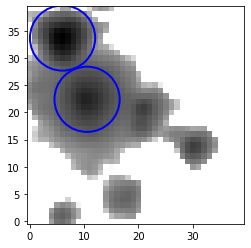

Time taken to fit PSF model: 0.041895200000002575s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.558737 22.404747 14393.408   1 ... 406.03147 499.17026  224.9201 -82.197158
6.0491247 33.675392 21949.119   2 ... 401.52186  510.4409 224.91632 -82.195201



Current star: RRL44
Star's pixel coordinates: (788.0450192271643, 144.97387342272174)


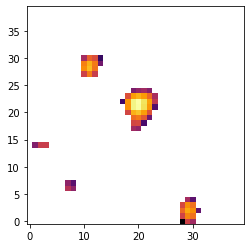

Number of PSF stars: 5


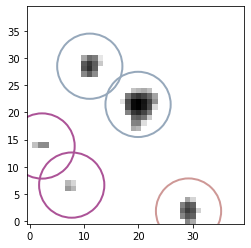

Time taken to fit PSF model: 0.05586549999999946s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 29.22341 1.8462508 825.01935   1 ... 797.26843 126.82012 224.80474  -82.28582
7.7349084 6.6200231 417.51345   2 ... 775.77993  131.5939 224.82269 -82.283054
2.2800458  13.81254 367.99745   3 ... 770.32507 138.78641 224.82284 -82.281549
19.939581 21.463234 2471.9738   4 ...  787.9846 146.43711 224.79957  -82.28227
11.058919 28.489477 949.20375   5 ... 779.10394 153.46335 224.80326 -82.280449



Current star: RRL45
Star's pixel coordinates: (418.0144709517903, 189.06754854066165)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


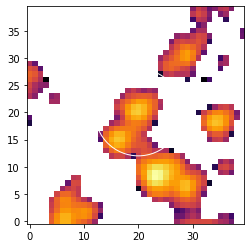

Number of PSF stars: 6


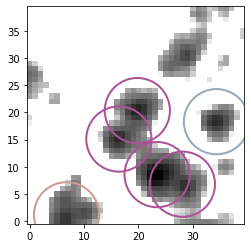

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0830055999999999s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.7873986  1.159205 2099.8021   1 ... 404.80187 170.22675 225.16294 -82.241033
28.091956 6.7803533 6069.1589   2 ... 426.10643  175.8479 225.13771 -82.242406
23.450472 8.5460961 6843.7523   3 ... 421.46494 177.61364   225.141 -82.241707
16.409205 15.098171 2895.4489   4 ... 414.42368 184.16572 225.14313  -82.24013
19.805328 20.324778 3154.3915   6 ...  417.8198 189.39233 225.13591 -82.239771
34.366832 18.288856 1679.1841   5 ...  432.3813  187.3564   225.123 -82.241494



Current star: RRL46
Star's pixel coordinates: (297.45280083830636, 290.4051071692927)

i am in de mask


Current star: RRL47
Star's pixel coordinates: (438.9015103539085, 235.39884509689716)

i am in de mask


Current star: RRL48
Star's pixel coordinates: (286.4067479332806, 194.29294590709367)


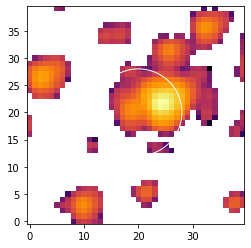

Number of PSF stars: 4


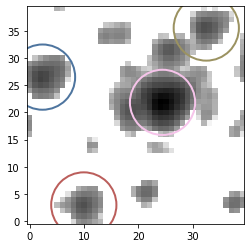

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08475560000000115s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.9584139 2.9660954 1938.9313   1 ... 276.36516 177.25904 225.28458 -82.227268
24.442284  21.83978 35484.108   2 ... 290.84903 196.13273 225.25634 -82.226199
 2.365868 26.484263 3542.4772   3 ... 268.77262 200.77721 225.27467 -82.223372
32.490765 35.515443 2318.0315   4 ... 298.89751 209.80839  225.2383 -82.225179
18.759114 20.529705 2922.6005   1 ... 285.16586 194.82265 225.26292 -82.225805



Current star: RRL49
Star's pixel coordinates: (280.2033556190063, 305.3944534286815)

i am in de mask


Current star: RRL50
Star's pixel coordinates: (134.40885456040178, 539.1118399959176)


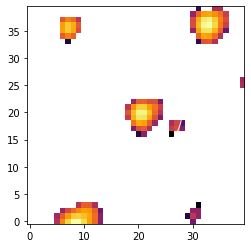

Number of PSF stars: 3


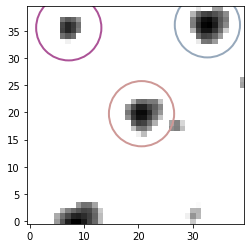

Time taken to fit PSF model: 0.045779199999998355s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.579268 19.755463 1991.3649   1 ... 134.98812  538.8673 225.15757 -82.164896
7.1927942 35.555904 789.92253   2 ... 121.60165 554.66774 225.15913 -82.161451
32.694335 36.105751 2350.9176   3 ... 147.10319 555.21759 225.13374  -82.16392



Current star: RRL51
Star's pixel coordinates: (317.1287094931349, 88.3750490161504)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


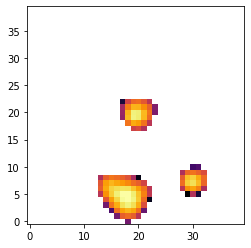

Number of PSF stars: 2


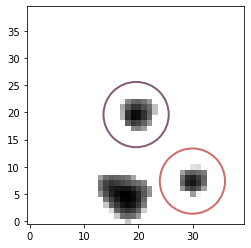

Time taken to fit PSF model: 0.04139290000000173s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.939838 7.3581454 1680.2066   1 ... 327.06855 75.733194 225.30972 -82.245874
19.582233 19.595648 2338.9794   2 ... 316.71094 87.970697 225.31088 -82.243207



Current star: RRL53
Star's pixel coordinates: (478.45240725914323, 352.1904649077255)

i am in de mask


Current star: RRL54
Star's pixel coordinates: (419.6085113153611, 395.2838049537124)

i am in de mask


Current star: RRL55
Star's pixel coordinates: (340.054107325932, 437.92728806945854)

i am in de mask


Current star: RRL56
Star's pixel coordinates: (528.4378205657072, 313.5160269289047)


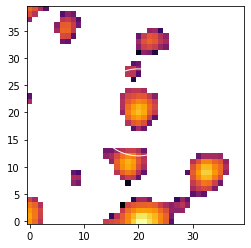

Number of PSF stars: 5


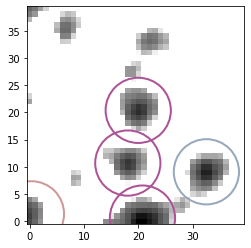

Time taken to fit PSF model: 0.06198209999999804s
   x_0        y_0       flux_0   id ...   x_true    y_true      RA       dec    
---------- ---------- --------- --- ... --------- --------- --------- ----------
0.32181703  1.3326261 756.87001   1 ... 508.75964 294.84865 224.96821 -82.234713
 20.749399 0.54763493 4030.8073   2 ... 529.18722 294.06366 224.94854 -82.236846
 18.054813  10.674256 1786.7645   4 ... 526.49263 304.19028 224.94378 -82.235223
 19.971661  20.369175 2214.9994   5 ... 528.40948  313.8852 224.93476 -82.234114
 32.509898   9.067779 2495.0634   3 ... 540.94772 302.58381 224.93062 -82.236872



Current star: RRL57
Star's pixel coordinates: (324.25069908874224, 229.9097193021136)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


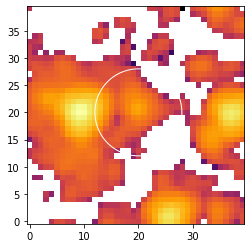

Number of PSF stars: 3


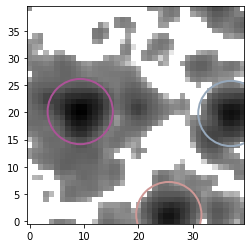

Time taken to fit PSF model: 0.05829650000000086s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
25.597858 1.1959325 12711.468   1 ... 329.84856 211.10565 225.20681 -82.228096
 9.301909 20.148155 45062.423   2 ... 313.55261 230.05787  225.2089  -82.22394
37.012363 19.793156 19046.359   3 ... 341.26306 229.70288 225.18182 -82.226753



Current star: RRL58
Star's pixel coordinates: (330.7074010336705, 432.6404210091759)

i am in de mask


Current star: RRL60
Star's pixel coordinates: (585.65611335463, 349.820491201665)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


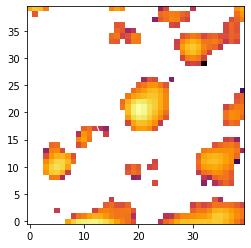

Number of PSF stars: 2


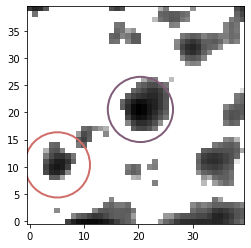

Time taken to fit PSF model: 0.05845809999999929s
   x_0       y_0      flux_0   id ...  x_true    y_true      RA       dec    
--------- --------- --------- --- ... -------- --------- --------- ----------
5.0953911 10.338292 -11.11916   1 ... 570.7515 340.15878 224.87349 -82.234791
20.371384 20.537253 1600.6738   2 ... 586.0275 350.35774 224.85086 -82.234937



Current star: RRL61
Star's pixel coordinates: (200.7828412540975, 347.1371734764915)


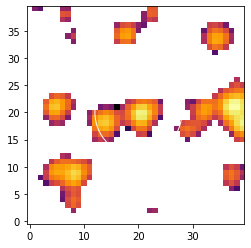

Number of PSF stars: 5


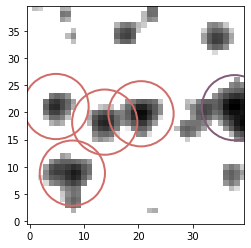

Time taken to fit PSF model: 0.0760165999999991s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
7.8531793 8.8222599 2378.7846   1 ... 188.63602 335.95943 225.25383 -82.197333
13.808864 18.200672 2009.2466   2 ... 194.59171 345.33784 225.24107 -82.196677
20.485133 19.738828 2589.6357   3 ... 201.26797   346.876 225.23338 -82.197139
4.8497078 21.074589 1293.6676   4 ... 185.63255 348.21176 225.24776 -82.195399
37.676149 20.857607  4116.548   5 ... 218.45899 347.99478 225.21566 -82.198706



Current star: RRL62
Star's pixel coordinates: (432.6522091994011, 186.88678838679715)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


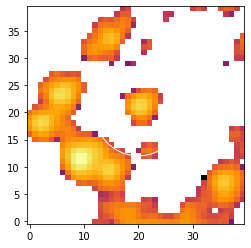

Number of PSF stars: 6


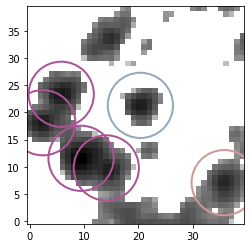

Time taken to fit PSF model: 0.07418780000000069s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.786079 7.0697265 1750.1988   1 ... 448.43829 173.95651   225.117 -82.244884
14.091956 9.7803533 5931.0987   2 ... 426.74417 176.66714 225.13647  -82.24236
9.4504716 11.546096 6705.6921   3 ... 422.10268 178.43288 225.13976 -82.241661
2.4062239 18.091382 2758.1831   4 ... 415.05843 184.97817  225.1419 -82.240085
5.8053277 23.324778 3016.3313   6 ... 418.45754 190.21157 225.13468 -82.239725
20.366832 21.288856 1528.7351   5 ... 433.01904 188.17564 225.12177 -82.241448



Current star: RRL63
Star's pixel coordinates: (127.4048292497157, 342.9503273287336)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


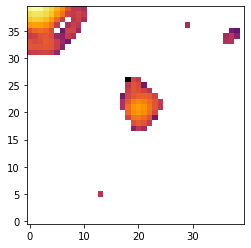

Number of PSF stars: 2


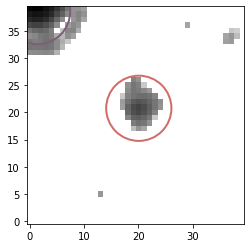

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.046273299999999296s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.074931 20.748265 2598.4746   1 ... 127.47976 343.69859 225.30817 -82.190186
 1.455963 38.542742 16055.016   2 ... 108.86079 361.49307 225.31332 -82.185951



Current star: RRL64
Star's pixel coordinates: (525.5191836042283, 483.1598740160687)


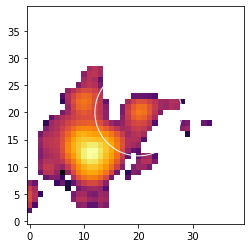

Number of PSF stars: 3


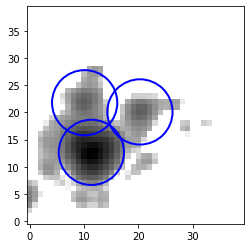

Time taken to fit PSF model: 0.09077789999999908s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.348442 12.643154 50734.985   1 ... 516.86763 475.80303 224.82764  -82.21127
 20.28468 20.079876 2773.8417   2 ... 525.80386 483.23975 224.81337 -82.211156
10.114889  21.77156 5168.1252   3 ... 515.63407 484.93143  224.8222 -82.209923



Current star: RRL65
Star's pixel coordinates: (308.9804300315917, 269.2671384503592)

i am in de mask


Current star: RRL66
Star's pixel coordinates: (450.49931475526455, 345.9835647177208)

i am in de mask


Current star: RRL67
Star's pixel coordinates: (459.75126180462246, 265.6602437517836)

i am in de mask


Current star: RRL69
Star's pixel coordinates: (292.62120328466284, 424.8655945635616)

i am in de mask


Current star: RRL71
Star's pixel coordinates: (226.80987228841224, 353.082643931314)


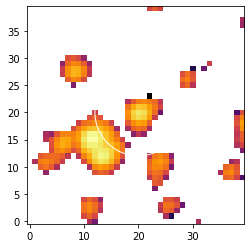

Number of PSF stars: 2


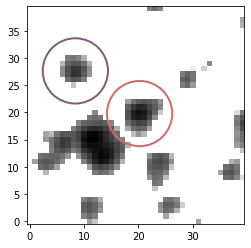

Time taken to fit PSF model: 0.050738800000001305s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.224094 19.780811 1876.1225   1 ... 227.03397 352.86345 225.20365 -82.198913
8.4019601 27.627214   842.244   2 ... 215.21183 360.70986  225.2095 -82.196685



Current star: RRL72
Star's pixel coordinates: (549.8297871492919, 670.6658762232405)


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


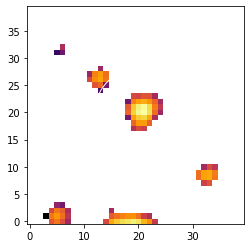

Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


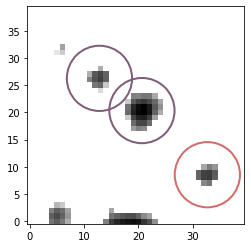

Time taken to fit PSF model: 0.059206499999998385s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
32.685624 8.5302847 786.54201   1 ... 562.51541 659.19616 224.64902 -82.191153
20.650409 20.328016 2182.7905   2 ...  550.4802 670.99389 224.65237 -82.188381
12.839025 26.256895 1006.4531   3 ... 542.66881 676.92277 224.65579 -82.186814



Current star: RRL74
Star's pixel coordinates: (329.0088873457214, 296.08190342319574)

i am in de mask


Current star: RRL75
Star's pixel coordinates: (346.5544034303484, 344.5049261296964)

i am in de mask


Current star: RRL76
Star's pixel coordinates: (326.8264290883757, 375.5299202676793)

i am in de mask


Current star: RRL77
Star's pixel coordinates: (379.8219720181463, 435.07736777542783)

i am in de mask


Current star: RRL79
Star's pixel coordinates: (264.9535214827199, 429.6078173859463)

i am in de mask


Current star: RRL80
Star's pi

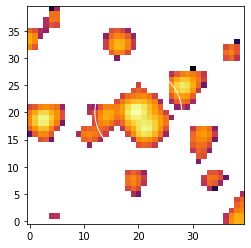

Number of PSF stars: 3


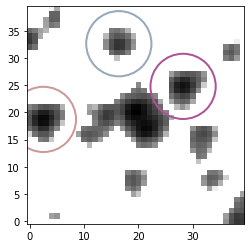

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.1945073999999991s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
2.5270231 18.703119 2122.5625   1 ...  200.7581 346.82534 225.23392 -82.197095
28.224094 24.780811 1898.4045   2 ... 226.45518 352.90304 225.20419  -82.19885
 16.40196 32.627214 864.52596   3 ... 214.63304 360.74944 225.21004 -82.196622
38.037391 1.0340191  608.6628   1 ... 236.26847 329.15624 225.21201 -82.202999



Current star: RRL81
Star's pixel coordinates: (480.9897237984438, 414.21327004604177)

i am in de mask


Current star: RRL82
Star's pixel coordinates: (397.9579100244474, 322.516587732783)

i am in de mask


Current star: RRL83
Star's pixel coordinates: (86.0409395572807, 434.22320731769486)


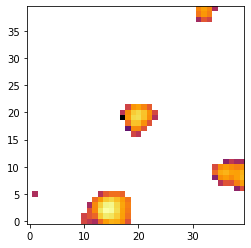

Number of PSF stars: 3


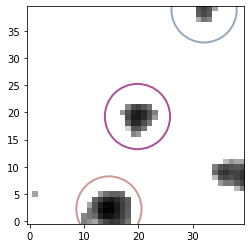

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05497670000000099s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
14.577464 2.2286025 3249.1376   1 ... 80.618404 416.45181 225.30057 -82.175799
19.827545 19.236575 1875.2079   2 ... 85.868484 433.45978 225.28294 -82.174057
32.082501 38.858605 480.23255   3 ...  98.12344 453.08181 225.25653 -82.172665



Current star: RRL84
Star's pixel coordinates: (363.7715311300342, 278.3498041001104)

i am in de mask


Current star: RRL85
Star's pixel coordinates: (401.3689648313201, 442.3464530598656)

i am in de mask


Current star: RRL86
Star's pixel coordinates: (369.880117383231, 403.82033128590393)

i am in de mask


Current star: RRL87
Star's pixel coordinates: (529.7890522839114, 272.61492932848626)


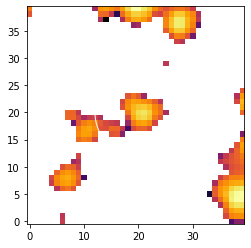

Number of PSF stars: 4


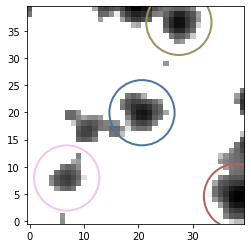

Time taken to fit PSF model: 0.05756560000000022s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
38.044368 4.5534367 2806.3455   1 ... 547.83342 257.16837 224.95717 -82.243637
6.8136354 7.9254519  873.3055   2 ... 516.60269 260.54038 224.98566 -82.240085
20.662214 19.937016 1901.7299   3 ... 530.45127 272.55195  224.9631 -82.239852
27.451225  36.55325 1892.9527   4 ... 537.24028 289.16818 224.94415 -82.238301



Current star: RRL89
Star's pixel coordinates: (287.7875678410861, 396.5315812515347)

i am in de mask


Current star: RRL90
Star's pixel coordinates: (219.42010934105872, 512.9033986651843)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


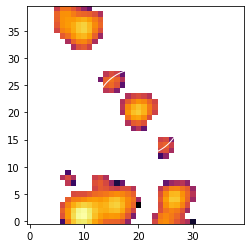

Number of PSF stars: 5


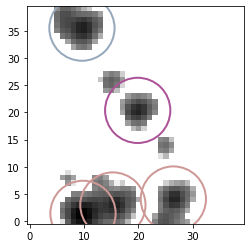

Time taken to fit PSF model: 0.059306899999999274s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.8103363 1.4211254  7713.465   1 ... 209.23045 494.32452 225.11735 -82.178246
15.308651 2.9542516 6896.6975   2 ... 214.72876 495.85765 225.11083 -82.178589
26.429913 4.0588704 2931.4195   3 ... 225.85002 496.96227  225.0991 -82.179549
19.873367 20.364358 2629.6479   4 ... 219.29348 513.26776 225.09361 -82.176716
9.6168358 35.492122 3994.2661   5 ... 209.03695 528.39552 225.09261 -82.173673



Current star: RRL91
Star's pixel coordinates: (210.49612398917634, 252.36001559909747)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


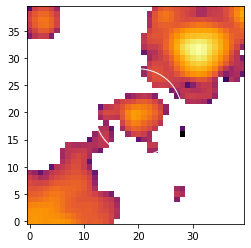

Number of PSF stars: 2


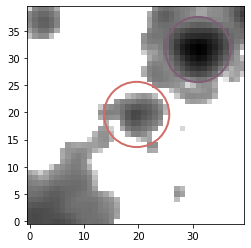

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08873960000000025s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
19.677264 19.614326 3441.9336   1 ... 210.17339 251.97434 225.29456 -82.210686
30.962982 31.563527 48109.189   2 ... 221.45911 263.92354 225.27464 -82.210221
2.0710102 1.4133672 5180.2913   1 ... 192.56713 233.77338 225.32531  -82.21135
38.503463 37.800797 1756.9357   2 ... 228.99959 270.16081 225.26262 -82.210143



Current star: RRL92
Star's pixel coordinates: (430.6085772272148, 579.8639863618685)


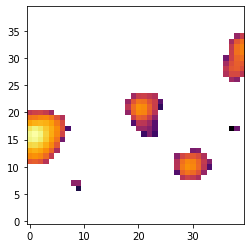

Number of PSF stars: 3


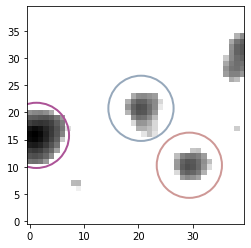

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05748489999999862s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.372918 10.271043 1927.7436   1 ... 439.98149 570.13503 224.83484  -82.19101
 1.243994 15.766138 15806.399   2 ... 411.85257 575.63012 224.85859 -82.187489
20.476871 20.743054 2073.5054   3 ... 431.08545 580.60704 224.83599 -82.188725



Current star: RRL93
Star's pixel coordinates: (460.1258599499282, 87.39634804363118)


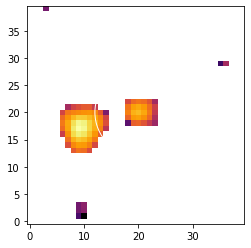

Number of PSF stars: 2


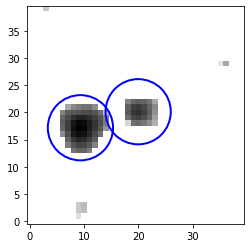

Time taken to fit PSF model: 0.06760949999999966s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.3374272  17.17103 7316.2707   1 ... 449.46329 84.567378 225.18208 -82.256925
19.958571 20.115849 2018.0572   2 ... 460.08443 87.512197 225.16937 -82.257592



Current star: RRL94
Star's pixel coordinates: (367.0575298402516, 469.18829852992957)

i am in de mask


Current star: RRL95
Star's pixel coordinates: (723.6849270995224, 242.67292762526318)


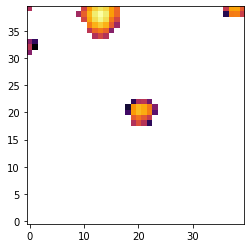

Number of PSF stars: 2


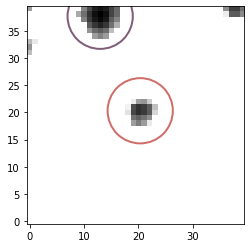

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.09352020000000039s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.335557  20.29273 1336.5789   1 ... 724.02048 242.96566 224.79241 -82.262994
12.970039 37.677182 3224.9893   2 ... 716.65497 260.35011 224.78698 -82.259933
37.572432 38.405052 514.46079   1 ... 741.25736 261.07798 224.76193 -82.262267



Current star: RRL96
Star's pixel coordinates: (327.72055082720516, 347.0989918405718)

i am in de mask


Current star: RRL97
Star's pixel coordinates: (353.7250547428218, 220.5210218970188)


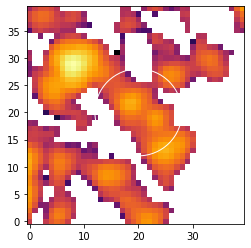

Number of PSF stars: 3


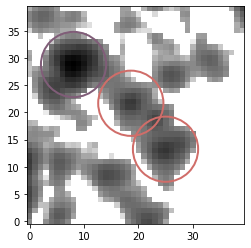

Time taken to fit PSF model: 0.0490200999999999s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
24.989348 13.226583 4048.2765   1 ...  358.7144  213.7476 225.17636 -82.230624
18.606345 21.674123 3127.6952   2 ...  352.3314 222.19514 225.17643  -82.22886
8.0742679 28.802524 21534.975   3 ... 341.79932 229.32355 225.18157 -82.226857



Current star: RRL98
Star's pixel coordinates: (454.8908207089036, 614.9565323726745)


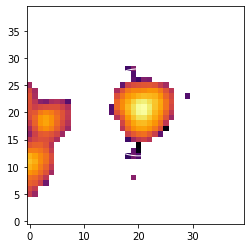

Number of PSF stars: 3


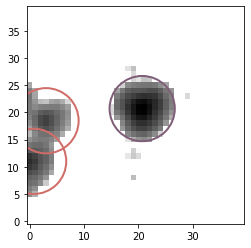

Time taken to fit PSF model: 0.06810620000000256s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
0.72563684 10.983611 6008.7573   1 ... 435.61646 605.94014 224.81308 -82.185776
 3.0058212 18.459518 5646.3345   2 ... 437.89664 613.41605 224.80539 -82.184999
 20.697608 20.696114 38314.369   3 ... 455.58843 615.65265 224.78631 -82.186448





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [4]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

tbl_CC.write('data/reference/CVSGC_'+cluster+'_reduced_readable.txt', format='csv', overwrite=True)

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

#xlim_hi = image_m.shape[1] - 30
#ylim_hi = image_m.shape[0] - 30
#xlim_lo = 30
#ylim_lo = 30
#print(xlim_hi, ylim_hi)

inmask = []
notinmask = []

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print("Star's pixel coordinates: ({0}, {1})".format(pix_crd[0], pix_crd[1]))
        
        if channel == '3p6um':
            rectloc = [1050, 340]
        if channel == '4p5um':
            rectloc = [360, 360]
        rectsize = 250
        rect = RectangularAperture(np.transpose(rectloc), rectsize, rectsize)
        
        limx_lo = rectloc[0] - 0.5*rectsize
        limx_hi = rectloc[0] + 0.5*rectsize
        limy_lo = rectloc[1] - 0.5*rectsize
        limy_hi = rectloc[1] + 0.5*rectsize
        
        if pix_crd[0] >= limx_lo and pix_crd[0] <= limx_hi and pix_crd[1] >= limy_lo and pix_crd[1] <= limy_hi:
            print('\ni am in de mask\n\n')
            inmask.append(star)
            continue
        else:
            notinmask.append(star)
        
        #if pix_crd[0] >= xlim_hi or pix_crd[0] <= xlim_lo or pix_crd[1] >= ylim_hi or pix_crd[1] <= ylim_lo:
        #    print('Star not in channel')
        #    not_ch_list.append(star)
            

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        #print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        
        try:
            pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        except TypeError:
            print('No sources detected')
            continue
            
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        #plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'_mask.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
        #break
        
#master_stars

In [38]:
print(len(notinmask))
print(len(inmask))
print(notinmask)
print(inmask)

46
39
[1, 2, 6, 7, 8, 10, 11, 15, 17, 18, 19, 20, 22, 24, 26, 29, 33, 34, 36, 38, 39, 41, 43, 44, 47, 49, 50, 55, 56, 59, 60, 61, 62, 63, 70, 71, 79, 82, 86, 89, 90, 91, 92, 94, 96, 97]
[0, 3, 4, 5, 9, 12, 13, 14, 16, 23, 27, 28, 30, 31, 35, 45, 46, 48, 52, 53, 54, 57, 64, 65, 66, 68, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 88, 93, 95]


In [5]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/IC4499/masterlist_RRL0_3p6um.txt
id_master    x_0        y_0      x_true    y_true      RA       dec    
--------- ---------- --------- --------- --------- --------- ----------
        0   36.42682 14.750808 966.87672 243.94323 225.20886 -82.216178
        1   1.204548 17.297522 931.65445 246.48994  225.2416 -82.212309
        2 0.96902109 22.916424 931.41892 252.10884 225.23767 -82.211537
        3  25.860344 21.987918 956.31024 251.18034 225.21389 -82.214156
        4  37.174182 29.689124 967.62408 258.88154 225.19707 -82.214263


In [26]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

remove_list_2 = []
for i in range(len(tbl_CC)):
    if i in inmask:
        remove_list_2.append(i)

print(remove_list_2)
print(tbl_CC)
tbl_CC.remove_rows(remove_list_2)

tbl_CC

Photometry method selected: PSF
[0, 3, 4, 5, 9, 12, 13, 14, 16, 17, 23, 27, 28, 30, 31, 35, 45, 48, 52, 53, 54, 57, 64, 65, 66, 68, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 88, 93, 95]
 ID      RA          dec      units period ... amplitude colour type id_new
--- ------------ ------------ ----- ------ ... --------- ------ ---- ------
  1 15h00m53.07s -82d12m49.8s    R0 0.6099 ...      0.74      V  RR0      0
  2 15h00m34.18s -82d14m25.0s    R0 0.4936 ...      1.21      V  RR0      1
  3 14h59m28.92s -82d14m39.6s    R0 0.4832 ...      1.21      V  RR0      2
  4 14h59m54.70s -82d12m38.1s    R0 0.6236 ...       0.8      V  RR0      3
  5 14h59m54.37s -82d13m39.7s    R0 0.5569 ...      1.11      V  RR0      4
  6 15h00m09.92s -82d12m17.2s    R0 0.5779 ...      0.96      V  RR0      5
  7 15h00m18.37s -82d09m24.5s    R0 0.6179 ...      0.78      V  RR0      6
  8 15h00m52.51s -82d11m08.8s    R0 0.3674 ...        --      V RR01      7
  9 15h00m44.34s -82d11m01.3s    R0 0.7096 ...      0.77

<Table length=59>
  ID       RA          dec      units  period ... amplitude colour type id_new
int32    str12        str12      str2 float64 ...  float64   str4  str5 int32 
----- ------------ ------------ ----- ------- ... --------- ------ ---- ------
    2 15h00m34.18s -82d14m25.0s    R0  0.4936 ...      1.21      V  RR0      1
    3 14h59m28.92s -82d14m39.6s    R0  0.4832 ...      1.21      V  RR0      2
    7 15h00m18.37s -82d09m24.5s    R0  0.6179 ...      0.78      V  RR0      6
    8 15h00m52.51s -82d11m08.8s    R0  0.3674 ...        --      V RR01      7
    9 15h00m44.34s -82d11m01.3s    R0  0.7096 ...      0.77      V  RR0      8
   11 15h00m58.85s -82d13m14.5s    R0  0.6315 ...      0.56      V  RR0     10
   12 15h01m05.04s -82d11m42.9s    R0  0.5948 ...      0.85      V  RR0     11
   16 14h59m38.04s -82d12m01.0s    R0  0.5773 ...      0.91      V  RR0     15
   19 14h58m53.33s -82d13m20.1s    R0  0.5306 ...      1.08      V  RR0     18
   20 14h59m56.63s -82d10m13.6s    R0  0.6482 ...      0.69      V  RR0     19
  ...          ...          ...   ...     ... ...       ...    ...  ...    ...
   92 15h01m07.73s -82d10m26.3s    R0  0.3547 ...      0.42      V  RR1     82
   97 14h59m51.29s -82d14m23.2s    R0  0.2883 ...      0.42      V  RR2     86
   98 15h02m16.88s -82d13m20.7s    R0  0.3556 ...      0.42      V  RR1     87
  106 15h00m22.50s -82d10m36.4s    R0  0.6277 ...      0.59      V  RR0     89
  108 15h01m10.55s -82d12m38.4s    R0  0.6415 ...      0.51      V  RR0     90
  109 14h59m20.88s -82d11m19.6s    R0  0.3555 ...        --      V RR01     91
  111 15h00m40.66s -82d15m27.4s    R0  0.3573 ...      0.42      V  RR1     92
  153 14h59m10.31s -82d15m46.8s    R0  0.2851 ...      0.31      V  RR2     94
  171 15h00m42.31s -82d13m45.2s    R0  0.2797 ...      0.22      V  RR2     96
  173 14h59m09.00s -82d11m11.3s    R0  0.3607 ...        --      V  RR1     97

### Main photometry cell:

In [ ]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

#remove_list_2 = []
#for i in range(len(tbl_CC)):
#    if i in inmask:
#        remove_list_2.append(i)
#        
#tbl_CC.remove_rows(remove_list_2)

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    if star in starlist:

        print('Current star: RRL{}'.format(star+1))

        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'_mask.txt'
        try:
            master_table = Table.read(master_file, format='ascii.csv')
        except FileNotFoundError:
            print('Star not in master list for this channel')
            continue

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
            
            print('Epoch: ', epoch)
            
            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:  
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])

            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.savefig('images/'+cluster+'/problem_stars/mask/RRL'+str(star+1)+'_'+channel+'_e'+str(epoch)+'.png')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###

                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)

                if sources_PSF == None:
                    print('No sources found initially :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)

                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('No sources found after reducing detection threshold :(')          

                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')

                    epoch += 1
                    continue

                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                #plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                #plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/mask/star'+str(star+1)+'_'+channel+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err', 'flux_unc'])

                mag_med = np.median(PSF_table['mag_err'])
                flux_med = np.median(PSF_table['flux_unc'])

                print('Median mag error:  {0}\nMedian flux error: {1}'.format(mag_med, flux_med))

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)

            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL{} not detected in this epoch :('.format(star+1))

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue

            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###

        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###

        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))

        for i in range(len(master_table_f)):

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv

        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)

        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/mask/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()


        print('\n\n')

        #break

        ###   END OF IF IN STARLIST CHECK   ###


    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    

    #if star == 1:
    #    break


    ###   END OF STAR LOOP   ###

remove_list_2 = []
for i in range(len(big_table)):
    if i in inmask:
        remove_list_2.append(i)
        
big_table.remove_rows(remove_list_2)

save_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [41]:
big_table.show_in_notebook()

In [10]:
file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

big_table_ch1 = Table()

for star in range(len(tbl_CC)):
    
    load_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
    if os.path.isfile(load_name) == True:
        pickle_in = open(load_name, 'rb')
        single_table = pickle.load(pickle_in)

        big_table_ch1 = vstack([big_table_ch1, single_table])
    
#big_table_ch1.show_in_notebook()
save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_ch1, pickle_out)
pickle_out.close()

In [42]:
load_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_3p6um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch1 = pickle.load(pickle_in)

big_table_ch1.show_in_notebook()

In [43]:
load_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_4p5um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch2 = pickle.load(pickle_in)

big_table_ch2.show_in_notebook()

### Run this to add Welch-Stetson variability index to huge_table:
I wouldn't run this if I were you

In [17]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq              I_var       
  str10       int32       float64  ...      float64             float64      
--------- -------------- --------- ... ------------------ -------------------
     RRL0              2  346.6729 ... 111.97863867238496   55.13041941431693
     RRL1              1 346.68512 ...  66.55609315558254 -10.376788119417483
     RRL2              1 346.67961 ...  190.2430713894951    14.7638680268631
     RRL3 -2.1474836e+09       nan ...                nan                 nan
     RRL4              0 346.65532 ... 20.148470438756682                 nan

### Plotting light curves:

Something else
Mags:  [15.818193632860744 15.823031630463714 15.775158222414905
 15.86908296583238 15.731121239882846 15.725384074643149
 15.760101472110502 15.85002802779255 15.82768536417499 15.791427432928597
 15.78221330905092 15.843944512299277]
Errs:  [0.050408604262062395 0.059666685170271246 0.05395162983660456
 0.0634452203558481 0.05551771256846038 0.04688161462958848
 0.05554994194819064 0.06128920785470207 0.059972338715073674
 0.05985157633995597 0.054780147146383636 0.10565973878540234]
Phase:  [0.10939459121436812 0.3040002216002904 0.4870391246222425
 0.6828878740197979 0.8565290544356685 0.05160310759674758
 0.2334109755756799 0.4482650129648391 0.6107876552850939
 0.8074923160602339 0.0013866005756426603 0.2084679025283549]


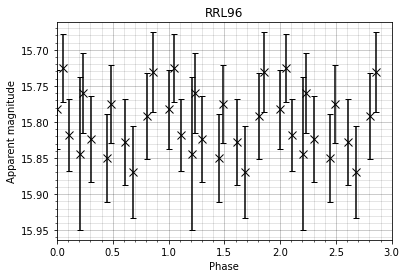

Chi squared:   7.188943862839401
IQR:           0.06818509097442949
von Neumann:   0.5252607102195892


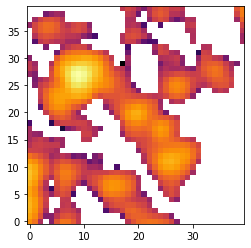

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


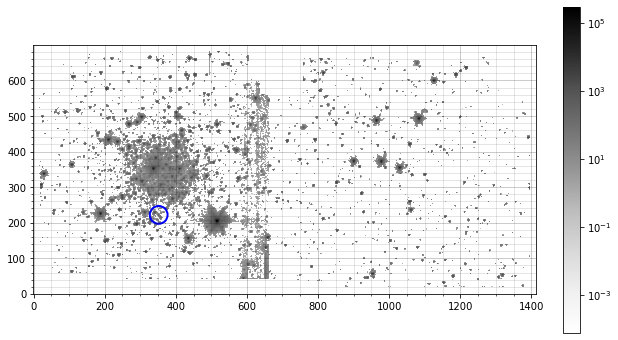

In [18]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 96
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period'][star_id]
        print('RRd')
    else:
        P = df_CC['period'][star_id]
        print('Something else')

    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    #plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###
    
    if cluster == 'PAL5':

        vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

        if os.path.isfile(vot_name) == True:

            votable = parse_single_table(vot_name)
            data_vot = votable.array

            temp = [i / P for i in data_vot['obs_time']]
            phase_vot = temp - np.floor(temp)

            mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
            phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

            plt.plot(phases_vot, mags_vot, 'kx')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.title('Gaia curve for RRL'+str(star_id))
            #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
            plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

In [23]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthese_ch1 = []
checkthese_ch2 = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthese_ch1.append(t_CC['id_new'][i])
    if t_CC['mean_mag_ch2'][i] < 15.4:
        checkthese_ch2.append(t_CC['id_new'][i])

print(checkthese_ch1)
print(checkthese_ch2)
t_CC.show_in_notebook()

[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]
[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 68, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]


### Running GLOESS:

In [6]:
file_CC = 'data/reference/CVSGC_IC4499_readable.txt'
df_ic = pd.read_csv(file_CC, sep=',', header=0)

df_ic

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0      1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1      2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2      3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3      4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4      5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..   ...           ...           ...   ...     ...          ...        ...   
130  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
131  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
132  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
133  172  15h00m16.85s  -82d11m33.7s    R0  0.0558       19.300       0.30   
134  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

    colour   type  
0        V    RR0  
1        V    RR0  
2        V    RR0  
3        V    RR0  
4        V    RR0  
..     ...    ...  
130      V    RR2  
131      V    RR0  
132      V    RR2  
133      V  SXPHE  
134      V    RR1  

[135 rows x 9 columns]

98
     ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  
0       V  RR0       0  
1       V  RR0       1

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.102    std dev = 0.086     amplitude = 0.265
<[4.5]> = 16.135    std dev = 0.062     amplitude = 0.202

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


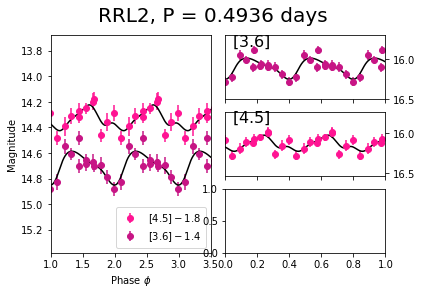

[nan, 0.02205767930696941]
new error ch1: 0.02205767930696941
new error ch2: 0.017552141856224394



RRab
Channel 1 mags:  [16.08996703 16.11011432 16.33861892 16.30359418 16.33947924 15.97145306
 15.9829214  15.99151626 16.08253132 99.         16.0945453  16.13183081]
Channel 2 mags:  [16.02047438 99.         16.08872279 16.16113679 16.1840448  15.97889293
 15.8823258  15.92557494 99.         15.99926547 16.14238768 16.18593872] 

RRL3 ---- Period = 0.4832 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.115    std dev = 0.104     amplitude = 0.325
<[4.5]> = 16.037    std dev = 0.096     amplitude = 0.274

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


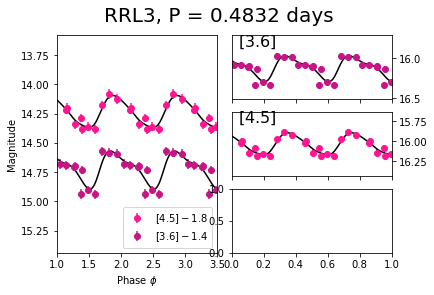

[nan, 0.02205767930696941, 0.028319874287772044]
new error ch1: 0.028319874287772044
new error ch2: 0.02497713111702254




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.95559097 15.67021373 16.01646958 15.93302003 15.9874559  15.64174126
 15.74567976 15.63849563 15.7897407  15.62167335 15.93015702 16.0707946 ]
Channel 2 mags:  [99.         99.         99.         99.         99.         99.
 15.7905455  15.7526059  99.         15.63992023 15.79764138 99.        ] 

RRL7 ---- Period = 0.6179 days
------------------------------------------------------
12 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.820    std dev = 0.092     amplitude = 0.256
<[4.5]> = 15.830    std dev = 0.107     amplitude = 0.354
Channels don't have the same number of measurements, so colour curve couldn't be plotted


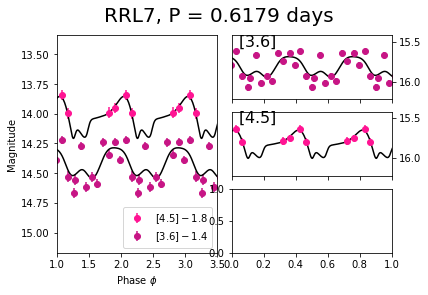

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446]
new error ch1: 0.021307906023734446
new error ch2: 0.05103889015521645



RRd
Channel 1 mags:  [15.82198823 15.90844379 15.89425384 16.00879137 99.         15.75326828
 15.97606081 16.97941237 15.89399337 15.8373441  16.56847136 15.96217553]
Channel 2 mags:  [15.78724102 15.91587326 15.87244284 15.93898533 15.88031125 15.73124514
 15.68397305 15.7341828  15.77993107 15.90538342 99.         15.78170217] 

RRL8 ---- Period = 0.3674 days
------------------------------------------------------
11 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.053    std dev = 0.163     amplitude = 0.480
<[4.5]> = 15.816    std dev = 0.075     amplitude = 0.219


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.237    std dev = 0.158     amplitude = 0.540


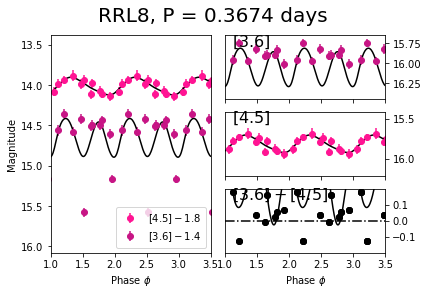

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088]
new error ch1: 0.04178438451200088
new error ch2: 0.019073310143958175



RRab
Channel 1 mags:  [15.90919773 15.83086191 15.86801284 15.71206129 15.74244345 15.65133956
 15.54932481 15.69675432 15.71818672 15.64519707 15.59478953 15.71694141]
Channel 2 mags:  [15.84789418 15.74419376 15.67793867 15.66355599 15.63420794 15.50785011
 15.55968517 15.53462327 15.64589698 15.61612879 15.70828673 15.62401232] 

RRL9 ---- Period = 0.7096 days
------------------------------------------------------
12 12
<[3.6]> = 15.718    std dev = 0.080     amplitude = 0.236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.654    std dev = 0.075     amplitude = 0.236
<[3.6] - [4.5]> = 0.064    std dev = 0.034     amplitude = 0.108


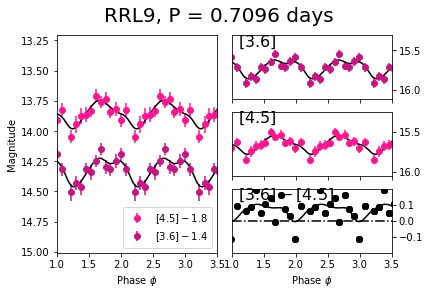

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741]
new error ch1: 0.0196692504600741
new error ch2: 0.019705055925177756




Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.75817388 15.72535474 15.73864063 15.80943113 15.85092704 15.89813438
 15.87847135 15.90463321 15.84941483 15.7598148  15.731949   15.68129407]
Channel 2 mags:  [15.69420247 15.60498307 15.72668309 15.64916908 15.77147605 15.85691876
 15.81121888 15.79176175 15.73427925 15.7175583  15.68787449 15.65678855] 

RRL11 ---- Period = 0.6315 days
------------------------------------------------------
12 12
<[3.6]> = 15.801    std dev = 0.064     amplitude = 0.175


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.728    std dev = 0.057     amplitude = 0.166
<[3.6] - [4.5]> = 0.073    std dev = 0.016     amplitude = 0.052


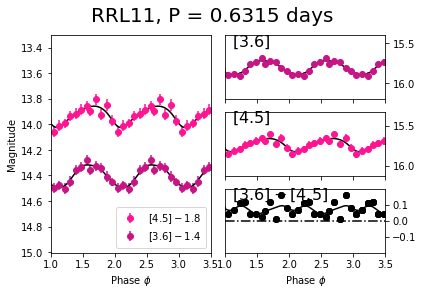

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329]
new error ch1: 0.014595259382162329
new error ch2: 0.01382719556600446



RRab
Channel 1 mags:  [15.97034625 15.95621248 15.98723901 15.91155494 15.93471648 15.94618696
 15.84159963 15.98726273 16.01211639 16.14925145 15.98975872 15.91862064]
Channel 2 mags:  [15.90879524 15.94323608 15.89020614 15.89099223 15.72446898 15.82921832
 15.86021582 15.91187948 16.00208338 15.9547324  16.00025816 15.97872521] 

RRL12 ---- Period = 0.5948 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.052     amplitude = 0.173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.065     amplitude = 0.191
<[3.6] - [4.5]> = 0.065    std dev = 0.036     amplitude = 0.123


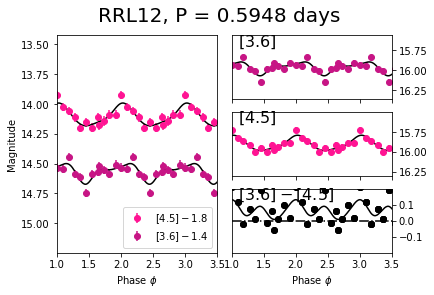

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757]
new error ch1: 0.014451822395278757
new error ch2: 0.01591443826410292




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.77053705 15.7674642  15.93960602 15.93376283 15.8298617  15.95564944
 16.01310218 15.98082186 15.86551851 15.79486066 15.7203626  15.80394838]
Channel 2 mags:  [15.77987166 15.78652817 15.84657042 15.86402428 15.94194193 15.98751186
 16.02012993 15.97123529 15.90302303 15.86030602 15.83476132 15.77183569] 

RRL16 ---- Period = 0.5773 days
------------------------------------------------------
12 12
<[3.6]> = 15.877    std dev = 0.078     amplitude = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.891    std dev = 0.077     amplitude = 0.221
<[3.6] - [4.5]> = -0.014    std dev = 0.039     amplitude = 0.131


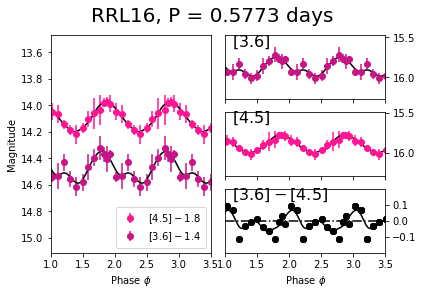

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957]
new error ch1: 0.02016614829715957
new error ch2: 0.01840078415101794




Star in forbidden zone (or is type "SR")

RRd
Channel 1 mags:  [16.07735712 16.11826434 16.13060525 16.02444404 16.00208707 16.00887491
 15.89116834 16.11006869 16.01978221 16.16745173 16.07040323 15.93443986]
Channel 2 mags:  [16.02632857 16.00067997 16.18326305 16.09985978 15.94018681 15.94886527
 15.92988911 15.95008401 16.05612984 16.08631557 15.97723875 15.98897822] 

RRL18 ---- Period = 0.3523 days
------------------------------------------------------
12 12
<[3.6]> = 16.034    std dev = 0.057     amplitude = 0.164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.010    std dev = 0.053     amplitude = 0.158
<[3.6] - [4.5]> = 0.024    std dev = 0.031     amplitude = 0.104


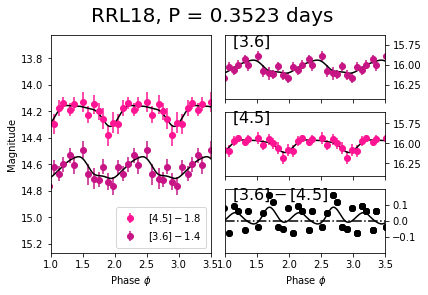

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019]
new error ch1: 0.013631998508266019
new error ch2: 0.013131574007811805



RRab
Channel 1 mags:  [16.28592702 16.11200813 15.99539348 15.99243616 15.89638505 16.02035399
 15.97722936 16.0586189  16.09434212 15.91782652 16.20195101 15.9586876 ]
Channel 2 mags:  [16.25743206 16.23255992 16.19655849 15.98278664 15.94133423 15.86636645
 15.87186192 16.0420035  15.94753548 15.96033159 16.24355203 16.20032595] 

RRL19 ---- Period = 0.5306 days
------------------------------------------------------
12 12
<[3.6]> = 16.028    std dev = 0.060     amplitude = 0.191


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.029    std dev = 0.120     amplitude = 0.358
<[3.6] - [4.5]> = -0.001    std dev = 0.096     amplitude = 0.285


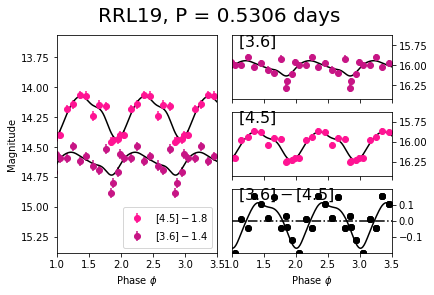

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143]
new error ch1: 0.015935665113477143
new error ch2: 0.02979787873573425



RRab
Channel 1 mags:  [15.76265842 15.84605193 15.68654859 15.76859427 15.65332493 15.87566882
 15.75941451 15.95880647 16.13019289 15.97649264 15.98498934 15.97177793]
Channel 2 mags:  [17.20397359 16.9963746  17.21233183 17.01461615 17.01134934 17.10038591
 16.98383462 17.11023256 16.90226702 17.0363812  16.96471578 17.19546   ] 

RRL20 ---- Period = 0.6482 days
------------------------------------------------------
12 12
<[3.6]> = 15.857    std dev = 0.116     amplitude = 0.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 17.055    std dev = 0.042     amplitude = 0.144
<[3.6] - [4.5]> = -1.198    std dev = 0.140     amplitude = 0.396


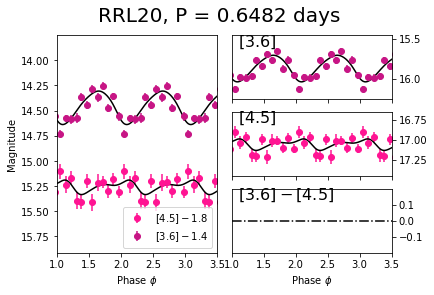

RRd
Channel 1 mags:  [16.02175483 16.15185426 16.23075773 16.31684879 16.14484101 16.13918879
 16.03642926 16.20688523 16.1260963  16.13222399 16.12050561 16.19629984]
Channel 2 mags:  [16.2256924  16.16353843 16.12564975 16.05284932 16.082998   16.05311107
 16.01030431 16.08816214 15.9611192  16.03224731 16.11163984 16.17860122] 

RRL21 ---- Period = 0.3533 days
------------------------------------------------------
12 12
<[3.6]> = 16.142    std dev = 0.046     amplitude = 0.148


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.085    std dev = 0.022     amplitude = 0.070
<[3.6] - [4.5]> = 0.057    std dev = 0.059     amplitude = 0.188


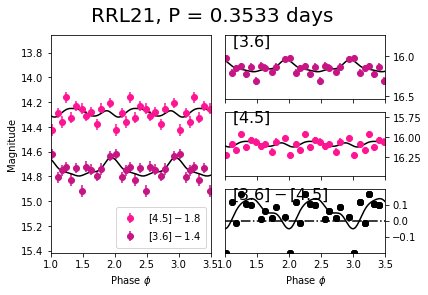

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366]
new error ch1: 0.012358852875342366
new error ch2: 0.005847356093989416



RRab
Channel 1 mags:  [16.45002514 16.46959824 16.5568807  16.50527014 16.46246809 16.53885453
 16.43709203 16.48629472 16.462642   16.36308576 16.54256596 16.65217959]
Channel 2 mags:  [] 

RRL22 ---- Period = 0.6747 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.495    std dev = 0.033     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


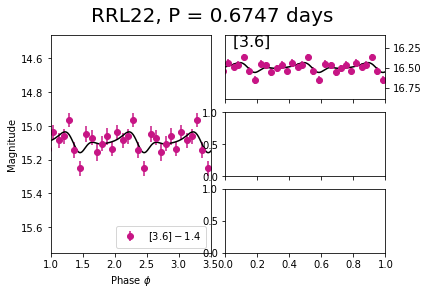

RRab
Channel 1 mags:  [16.17617653 16.14464581 16.08683989 15.95471747 15.91349249 16.0009054
 15.92318156 16.0817096  16.10294641 16.04404961 16.14824257 16.10517928]
Channel 2 mags:  [16.06883456 16.16183955 15.92836989 15.78866142 15.91900852 15.89024843
 15.87562451 15.8894838  16.05359232 16.12969128 16.14605557 16.06212166] 

RRL23 ---- Period = 0.5077 days
------------------------------------------------------
12 12
<[3.6]> = 16.039    std dev = 0.072     amplitude = 0.202


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.969    std dev = 0.097     amplitude = 0.266
<[3.6] - [4.5]> = 0.069    std dev = 0.034     amplitude = 0.110


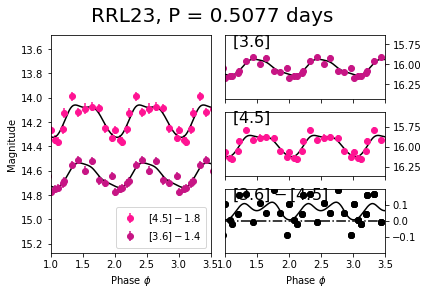

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719]
new error ch1: 0.01684938417110719
new error ch2: 0.022165795155387524




Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [99.         15.69962267 15.74928898 15.66606431 99.         15.63511391
 15.73881422 15.63284513 15.76485288 15.77880757 15.62817766 15.85986978]
Channel 2 mags:  [15.83536925 15.92512779 15.70846746 15.63030661 15.64733412 15.61779887
 15.62536458 15.69908229 15.67434028 15.74049154 15.75355783 15.83573223] 

RRL25 ---- Period = 0.6022 days
------------------------------------------------------
10 12
<[3.6]> = 15.710    std dev = 0.033     amplitude = 0.103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.714    std dev = 0.076     amplitude = 0.225
Channels don't have the same number of measurements, so colour curve couldn't be plotted


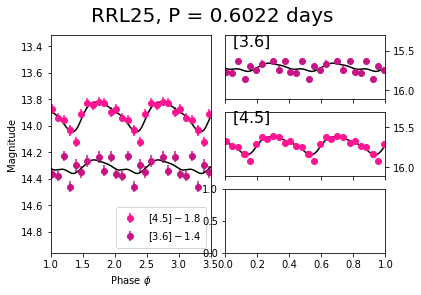

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076]
new error ch1: 0.009366173836899076
new error ch2: 0.018726279838450804



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.95387412 15.98772608 15.9083224  15.96346818 15.91580267 15.99468315
 16.18493836 16.25093491 16.24635668 15.89840978 15.95293189 16.00145894]
Channel 2 mags:  [15.94410141 16.01662856 15.99125039 15.98910978 15.95392355 15.96398587
 15.93084424 16.10884465 16.19582228 16.02511219 15.98065287 15.89302687] 

RRL27 ---- Period = 0.5068 days
------------------------------------------------------
12 12
<[3.6]> = 16.036    std dev = 0.107     amplitude = 0.305


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.002    std dev = 0.057     amplitude = 0.174
<[3.6] - [4.5]> = 0.034    std dev = 0.075     amplitude = 0.228


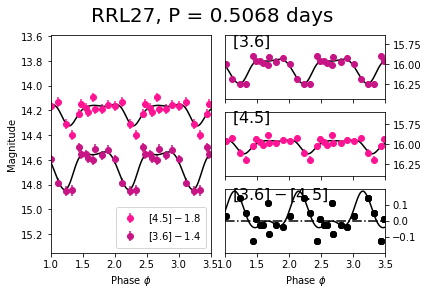

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902]
new error ch1: 0.02541749839552902
new error ch2: 0.014474421280207187




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.97025726 15.95140177 16.04741672 16.15890477 15.92648448 15.86141791
 15.82823838 15.89946849 15.96382094 15.85076061 15.94037749 15.92628286]
Channel 2 mags:  [15.90692868 15.93870751 15.95557797 16.03397121 16.07360269 15.75089831
 15.82013524 15.94265569 15.93733676 99.         15.91880692 15.99558284] 

RRL30 ---- Period = 0.5289 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.938    std dev = 0.066     amplitude = 0.218
<[4.5]> = 15.930    std dev = 0.061     amplitude = 0.220
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


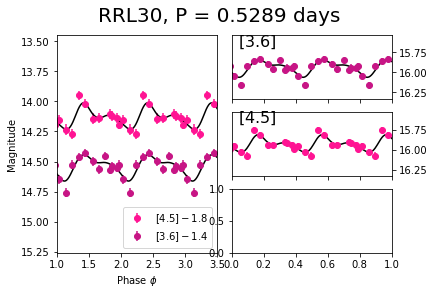

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218]
new error ch1: 0.01819808922893218
new error ch2: 0.019174929170803608




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.97988845 16.15073737 16.29583087 16.1781573  16.35742392 16.1205889
 16.02761412 15.94190527 15.91750876 16.1301271  15.94594196 16.06103249]
Channel 2 mags:  [16.06109544 16.12353543 16.1396938  16.3240075  16.3469577  16.17813223
 15.97557952 16.00623463 16.03918909 16.15013134 16.08228352 16.04245704] 

RRL34 ---- Period = 0.4936 days
-----------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.130    std dev = 0.102     amplitude = 0.334
<[3.6] - [4.5]> = -0.041    std dev = 0.031     amplitude = 0.104


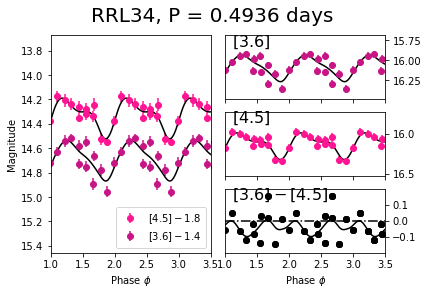

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106]
new error ch1: 0.02764399924573106
new error ch2: 0.027818886560578477



RRab
Channel 1 mags:  [15.66933892 15.57136231 99.         15.65802211 99.         15.72534349
 15.77764695 99.         15.61772908 15.62697717 15.48417989 15.5812578 ]
Channel 2 mags:  [15.61068108 15.52381405 15.63823519 15.61255174 15.6955665  15.77290169
 15.74389445 15.76316602 15.65253768 15.57023174 15.56244993 15.61898462] 

RRL35 ---- Period = 0.6498 days
------------------------------------------------------
9 12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.644    std dev = 0.061     amplitude = 0.195
<[4.5]> = 15.648    std dev = 0.066     amplitude = 0.182
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


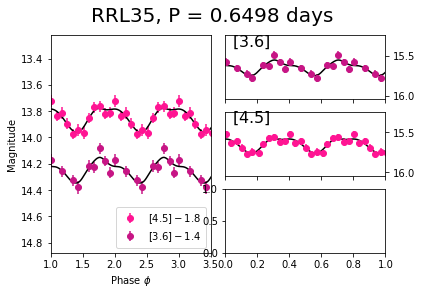

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126]
new error ch1: 0.01871798176793126
new error ch2: 0.015188076796218475




Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.83111498 15.85749669 15.98519357 16.00203594 15.97752274 16.05446752
 15.95251833 15.86777475 15.8006041  15.77401312 15.82193415 15.80843883]
Channel 2 mags:  [15.80789687 15.83681441 15.83849566 15.86223482 15.8606728  16.02256729
 15.80072402 15.81978603 15.76254367 15.71528749 15.74364861 15.77121519] 

RRL37 ---- Period = 0.6123 days
------------------------------------------------------
12 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


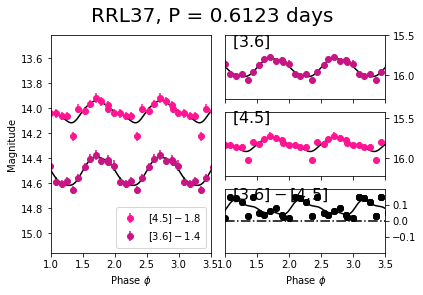

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416]
new error ch1: 0.018725618383013416
new error ch2: 0.014858072864653534



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.8317743  15.80978728 15.83315739 15.72685108 15.82916105 15.88124492
 15.91467411 16.0590859  16.04551271 15.82443524 15.74608172 15.8092162 ]
Channel 2 mags:  [15.72321813 15.80821513 15.78055972 15.85148049 15.81911963 15.84310356
 15.86432647 15.89229625 16.02168334 15.97337878 15.8064542  15.87523304] 

RRL39 ---- Period = 0.5365 days
-----------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.862    std dev = 0.052     amplitude = 0.163
<[3.6] - [4.5]> = 0.009    std dev = 0.046     amplitude = 0.145


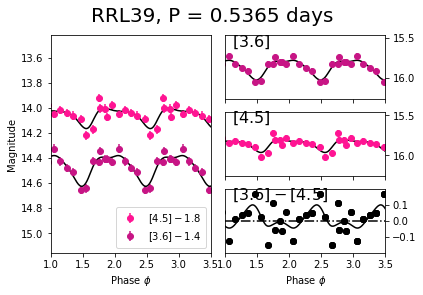

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545]
new error ch1: 0.020445225143792545
new error ch2: 0.013573617713134775



RRd
Channel 1 mags:  [17.24771252 17.33637531 99.         99.         99.         16.53051947
 16.38332599 17.51542768 99.         16.42704945 99.         17.36206515]
Channel 2 mags:  [99.         17.55785941 99.         17.38240483 17.38743916 99.
 99.         17.42593525 99.         99.         99.         99.        ] 

RRL40 ---- Period = 0.3615 days
------------------------------------------------------
7 4

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.831    std dev = 0.332     amplitude = 1.029
<[4.5]> = 17.405    std dev = 0.032     amplitude = 0.133
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


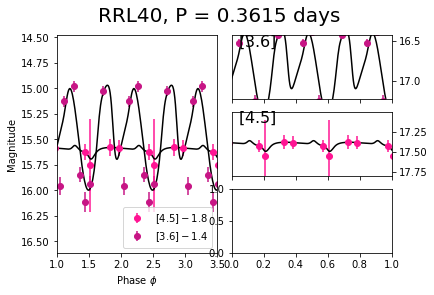

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [14.70788894 14.81568745 14.76411963 14.68279937 14.78648506 14.65489477
 14.74636727 14.69054285 14.73948173 14.70929989 14.77927021 14.74152668]
Channel 2 mags:  [14.57470855 14.50099609 14.50142862 14.52531272 14.53975509 14.58148106
 14.53323711 14.58077105 14.57226101 14.56830434 14.51183585 14.51448228] 

RRL42 ---- Period = 0.5254 days
------------------------------------------------------
12 12
<[3.6]> = 14.730    std dev = 0.020     amplitude = 0.061
<[4.5]> = 14.546    std dev = 0.023     amplitude = 0.071


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.185    std dev = 0.042     amplitude = 0.123


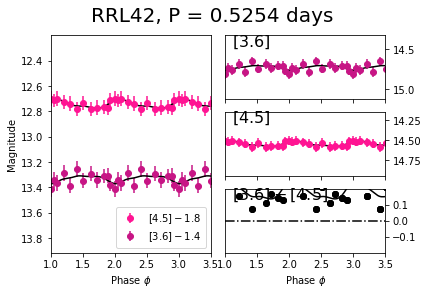

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  []
Channel 2 mags:  [17.73411079 15.94072604 16.0758434  16.17007593 15.80151541 17.8712648
 15.80308531 15.77930492 15.74004876 15.88156317 15.85002115 16.41619445] 

RRL44 ---- Period = 0.5599 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.940    std dev = 0.133     amplitude = 0.374
Channels don't have the same number of measurements, so colour curve couldn't be plotted


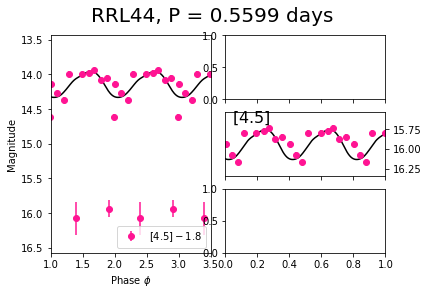

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan]
new error ch1: nan
new error ch2: 0.03118914559677736



RRab
Channel 1 mags:  [15.9288828  15.89522965 16.02898789 16.00918344 16.04507279 16.01712176
 15.89275189 15.8699589  15.86902281 15.7053566  15.86182734 15.92202804]
Channel 2 mags:  [15.7569994  15.87603073 15.88381047 15.96087481 15.97302714 15.84543989
 15.84845023 15.74517222 15.8581738  15.8582946  15.85801302 15.81407632] 

RRL45 ---- Period = 0.5833 days
------------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.861    std dev = 0.046     amplitude = 0.140
<[3.6] - [4.5]> = 0.059    std dev = 0.053     amplitude = 0.170


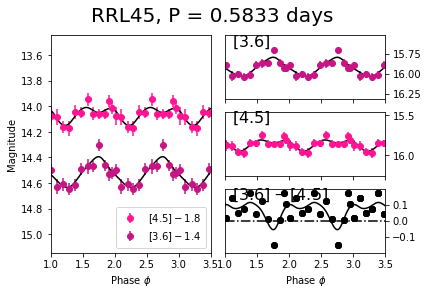

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092]
new error ch1: 0.01997602667697092
new error ch2: 0.011689666638514229




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.80027791 99.         15.97115833 15.74125266 15.79513887 15.87820864
 16.35627622 99.         15.65471656 15.86034004 15.74792846 15.80463547]
Channel 2 mags:  [99.         99.         99.         16.0193543  15.84955871 15.86186344
 99.         99.         1

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:68: RuntimeWarning: invalid value encountered in sqrt
  sigma_c2=np.sqrt(ai22)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ai11=cofa11/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:52: RuntimeWarning: invalid value encountered in double_scalars
  ai12=cofa21/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:53: RuntimeWarning: invalid value encountere

<[3.6]> = 15.844    std dev = 0.095     amplitude = 0.338
<[4.5]> = 15.948    std dev = 0.101     amplitude = 0.297
Channels don't have the same number of measurements, so colour curve couldn't be plotted


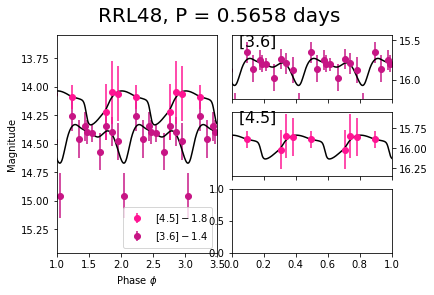

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023]
new error ch1: 0.03083994437805023
new error ch2: 0.042936318545389




Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [16.00354504 16.07692224 16.0324734  16.10340186 15.85439123 15.99353532
 15.98494879 15.93412868 15.93862553 16.0170203  16.04561582 15.9357012 ]
Channel 2 mags:  [15.9767837  16.02554036 16.02261863 16.10442633 15.99131945 16.02998774
 15.90792241 15.95653034 16.0444405  15.8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.001    std dev = 0.041     amplitude = 0.149


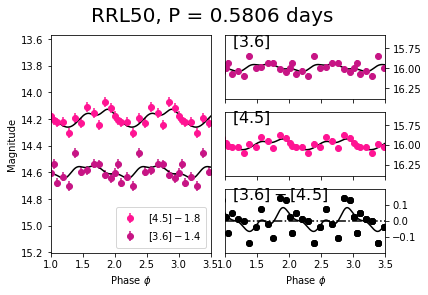

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556]
new error ch1: 0.007891469496489556
new error ch2: 0.011171376290898186



RRab
Channel 1 mags:  [15.64577209 15.99093971 15.75101838 15.78715174 15.92555535 15.78285624
 16.35478792 15.91848182 15.87189235 15.86330924 15.68581833 15.72147221]
Channel 2 mags:  [15.73942973 15.94439633 15.82461484 15.81289676 99.         15.90767468
 15.98788872 15.79742418 99.         99.         15.6

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.859    std dev = 0.096     amplitude = 0.316
<[4.5]> = 15.817    std dev = 0.081     amplitude = 0.268
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


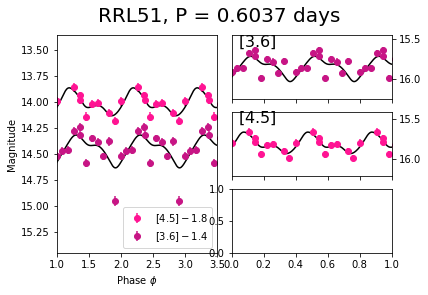

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696]
new error ch1: 0.0263297047389696
new error ch2: 0.025807150919949257



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 


Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  [15.8288475  15.98132427 16.10804907 16.120271   15.98013645 15.96643531
 16.09210971 15.9341218

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


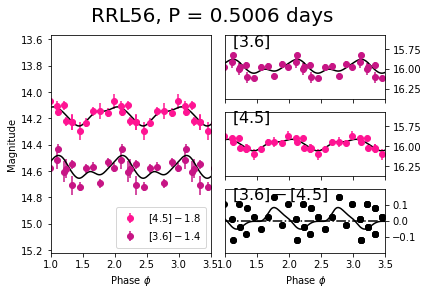

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612]
new error ch1: 0.01441594851329612
new error ch2: 0.012081822523256106



RRd
Channel 1 mags:  [12.62294119 12.59545243 12.65985619 12.64731191 12.55086946 12.60646122
 12.57552975 12.61461241 12.66992822 12.56819883 12.60962597 12.56328107]
Channel 2 mags:  [12.58316782 12.56729352 12.64524654 12.64967408 12.69895048 12.537

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = -0.018    std dev = 0.031     amplitude = 0.115


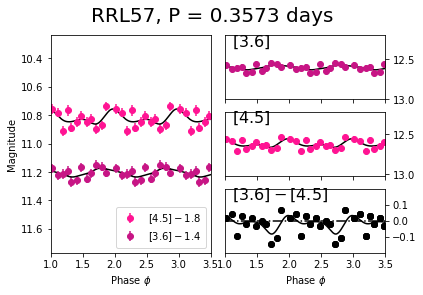


Star in forbidden zone (or is type "SR")

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRd
Channel 1 mags:  [16.33177001 16.31187729 16.23064056 16.13024401 16.06856935 16.1100166
 16.1815929  16.29098885 16.19636339 15.98483602 16.0312019  16.10762074]
Channel 2 mags:  [16.16174949 99.         16.10152615 16.03118788 16.01720646 16.0917715
 16.23486599 99.         16.24569791 16.18426347 16.15818806 16.06066337] 

RRL60 ---- Period = 0.3578 days
------------------------------------------------------
12 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.162    std dev = 0.087     amplitude = 0.245
<[4.5]> = 16.138    std dev = 0.056     amplitude = 0.160
Channels don't have the same number of measurements, so colour curve couldn't be plotted


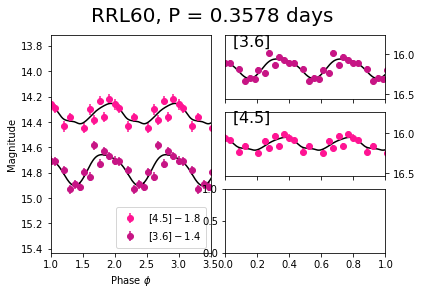

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738]
new error ch1: 0.020382889740956738
new error ch2: 0.014646449698635572



RRab
Channel 1 mags:  [15.8848578  15.99890518 15.95912398 16.02974915 15.74395865 15.87357579
 15.85114578 15.72178228 15.83595355 15.87626744 15.92342489 15.81976794]
Channel 2 mags:  [15.88568653 15.97412353 15.

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.874    std dev = 0.054     amplitude = 0.179
<[4.5]> = 15.809    std dev = 0.109     amplitude = 0.328
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


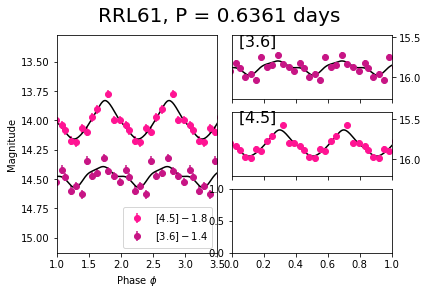

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738]
new error ch1: 0.014927759422480738
new error ch2: 0.028568573721776406



RRd
Channel 1 mags:  [16.1896533  16.03961562 16.15745228 16.14538789 16.2170566  16.2686903
 16.20330821 16.06819738 16.21469338 15.9948623  16.1868021  16.23449408]
Channel 2 mags:  [16.1466

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.162    std dev = 0.011     amplitude = 0.038
<[3.6] - [4.5]> = 0.003    std dev = 0.049     amplitude = 0.141


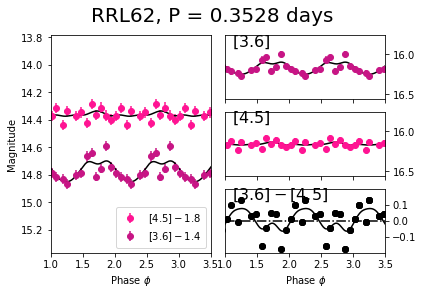

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248]
new error ch1: 0.012620808577274248
new error ch2: 0.003170625862118174



RRab
Channel 1 mags:  [15.94019329 15.96420487 15.87654548 15.81981649 15.6819578  15.75107359
 15.79074855 15.75504768 15.83742729 15.99414389 15.97985151 15.81484973]
C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


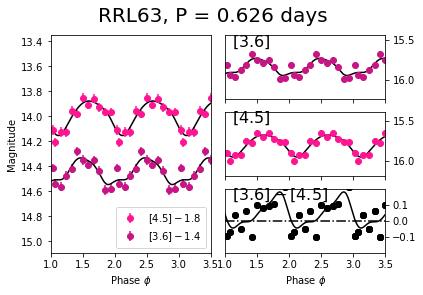

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637]
new error ch1: 0.01779479145943637
new error ch2: 0.02303313497244878



RRc
Channel 1 mags:  [16.01821594 16.13412928 16.28265769 16.38464605 16.61152932 16.59606138
 16.15415477 16.2919999  16.533605   16.46687713 16.33607

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.269    std dev = 0.052     amplitude = 0.161
<[3.6] - [4.5]> = 0.017    std dev = 0.121     amplitude = 0.355


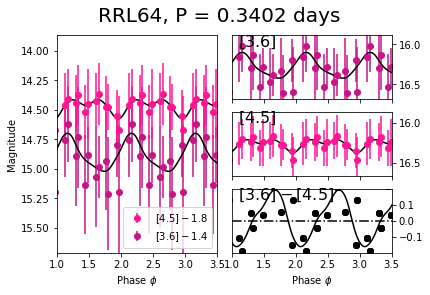

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589]
new error ch1: 0.02679323088976589
new error ch2: 0.013400786506440276




Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")


Star in forbidden zone (or is type "SR")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.836    std dev = 0.068     amplitude = 0.187
Channels don't have the same number of measurements, so colour curve couldn't be plotted


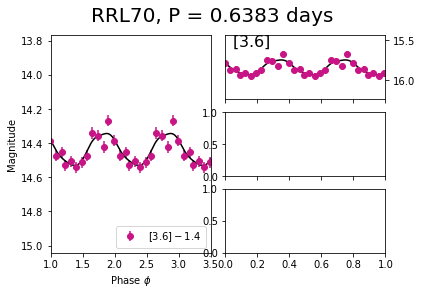

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924]
new error ch1: 0.015547056280382924
new error ch2: nan



RRc
Channel 1 mags:  [16.05595861 16.10962625 16.16575095 16.24510568 16.17401004 16.14121826
 16.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.089    std dev = 0.039     amplitude = 0.114
<[3.6] - [4.5]> = 0.064    std dev = 0.028     amplitude = 0.090


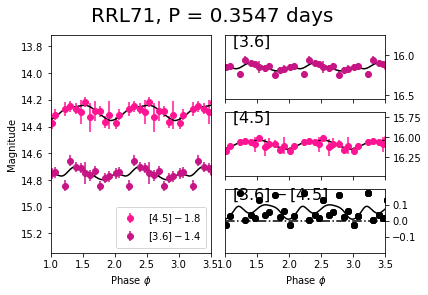

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866]
new error ch1: 0.008230332497542866
new error ch2: 0.009491446050346871



RRd
Channel 1 mags:  [16.32528026 16.17162912 15.97409704 9

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.166    std dev = 0.092     amplitude = 0.308
<[4.5]> = 16.214    std dev = 0.065     amplitude = 0.204
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


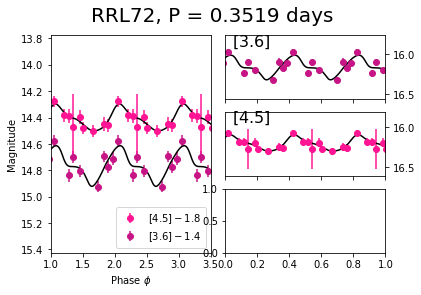

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837]
new error ch1: 0.03139227939433837
new error ch2: 0.019613735011666748



RRab
Channel 1 mags:  []
Channel 2 mags

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.086    std dev = 0.026     amplitude = 0.083
<[3.6] - [4.5]> = 0.068    std dev = 0.037     amplitude = 0.117


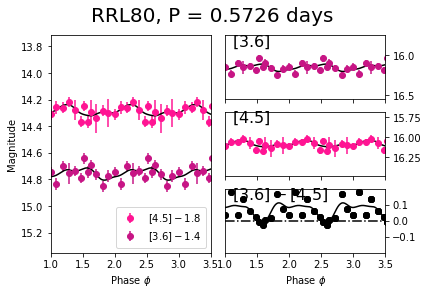

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763]
new error ch1: 0.007677137609318763
new error ch2: 0.006

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.196    std dev = 0.020     amplitude = 0.065
<[4.5]> = 16.140    std dev = 0.100     amplitude = 0.339


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Channels don't have the same number of measurements, so colour curve couldn't be plotted


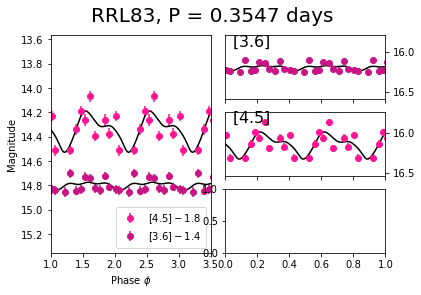

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336]
new error ch1: 0.0053954

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.217    std dev = 0.052     amplitude = 0.151


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.210    std dev = 0.061     amplitude = 0.192
Channels don't have the same number of measurements, so colour curve couldn't be plotted


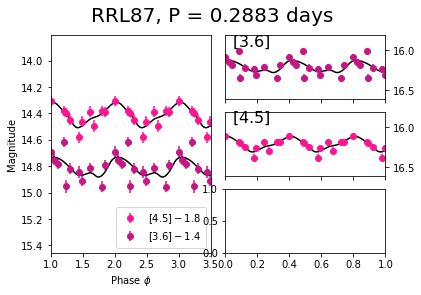

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.814    std dev = 0.060     amplitude = 0.178
<[3.6] - [4.5]> = 0.070    std dev = 0.043     amplitude = 0.141


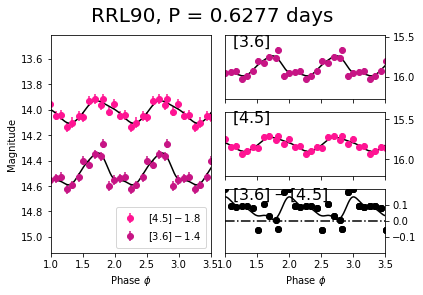

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.647    std dev = 0.052     amplitude = 0.146
<[3.6] - [4.5]> = 0.027    std dev = 0.015     amplitude = 0.062


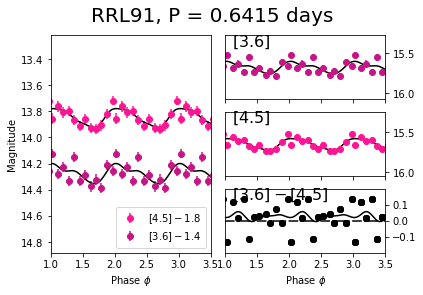

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.120    std dev = 0.066     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.159    std dev = 0.112     amplitude = 0.340
<[3.6] - [4.5]> = -0.039    std dev = 0.068     amplitude = 0.235


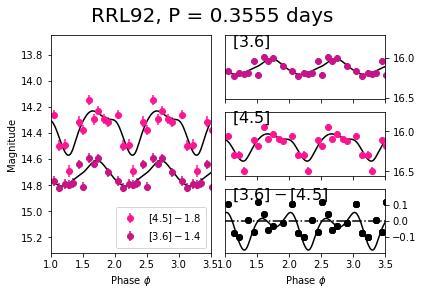

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.168    std dev = 0.132     amplitude = 0.414


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.192    std dev = 0.043     amplitude = 0.143
<[3.6] - [4.5]> = -0.024    std dev = 0.156     amplitude = 0.517


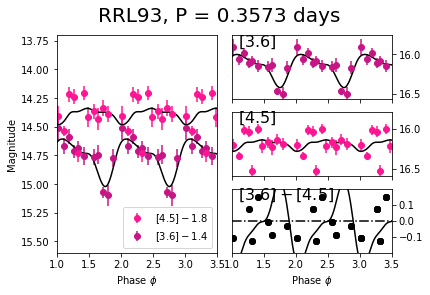

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.309    std dev = 0.033     amplitude = 0.107
Channels don't have the same number of measurements, so colour curve couldn't be plotted


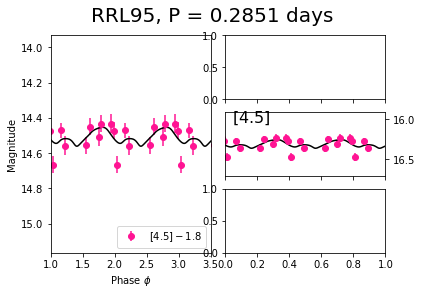

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, nan, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.795    std dev = 0.026     amplitude = 0.086
<[3.6] - [4.5]> = 0.088    std dev = 0.125     amplitude = 0.371


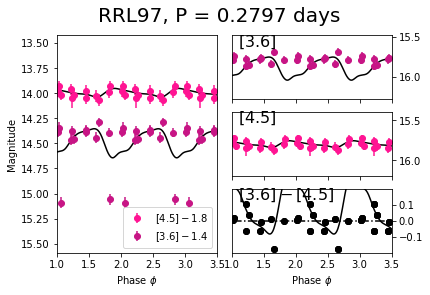

RRc
Channel 1 mags:  [12.91396909 12.92855412 12.67245627 12.70173465 12.62723084 12.59125913
 12.86814507 12.62855301 12.58756584 12.99295035 12.73675083 12.62667131]
Channel 2 mags:  [12.82427599 12.79233471 99.         12.83110764 99.         12.77135066
 12.76280071 12.68692698 99.         12.83742197 12.90013897 12.85768218] 

RRL98 ---- Period = 0.3607 days
------------------------------------------------------
12 9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 12.737    std dev = 0.066     amplitude = 0.225
<[4.5]> = 12.809    std dev = 0.036     amplitude = 0.105

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


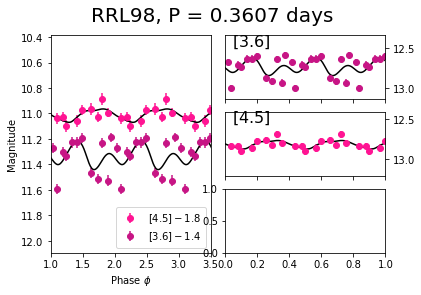

98
[nan, 16.062549046114, 16.07514475715958, nan, nan, nan, 15.7801954817224, 16.01436604890409, 15.679308001507556, nan, 15.761648965163737, 15.928938471000391, nan, nan, nan, 15.837110240504098, nan, 15.99410115463008, 15.987823548500344, nan, 16.10275323071839, nan, 15.999854031494975, nan, 15.67024307628635, nan, 15.99737901538643, nan, nan, 15.898605252823803, nan, nan, nan, 16.049486433483978, 15.604707889222606, nan, 15.859879574307694, nan, 15.830914024157257, nan, nan, nan, nan, nan, 15.880644667004951, nan, nan, 15.803672489732563, nan, 15.951438296780513, 15.819271321621434, nan, nan, nan, nan, 15.940986078869626, nan, nan, nan, 16.122376178691418, 15.835330861876374, 16.126595724252482, 15.806821181066642, 16.246031686418394, nan, nan, nan, nan, nan, 15.79539268398306, 16.114394912989045, 16.125572861156783, nan, nan, nan, nan, nan, nan, nan, 16.115466633272938, nan, nan, 16.15673790440372, nan, nan, nan, 16.17668772975797, nan, nan, 15.844792548093572, 15.635446237264775, 

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...                   NaN                   NaN   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...                   NaN                   NaN   
4       V  RR0       4  ...                   NaN                   NaN   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...                   NaN                   NaN   
94      V  RR2      94  ...              0.010328                   NaN   
95      V  RR0      95  ...                   NaN                   NaN   
96      V  RR2      96  ...                   NaN                   NaN   
97      V  RR1      97  ...                   NaN                   NaN   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0                    NaN                   NaN                   NaN   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
..                   ...                   ...                   ...   
93                   NaN                   NaN                   NaN   
94              0.016311                   NaN              0.016480   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0         NaN    NaN    NaN       NaN       NaN  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3         NaN    NaN    NaN       NaN       NaN  
4         NaN    NaN    NaN       NaN       NaN  
..        ...    ...    ...       ...       ...  
93        NaN    NaN    NaN       NaN       NaN  
94   0.381942  0.041  0.034       NaN  0.107336  
95        NaN    NaN    NaN       NaN       NaN  
96   0.374708  0.039  0.033       NaN       NaN  
97   0.483221  0.040  0.033       NaN       NaN  

[98 rows x 27 columns]

In [19]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

#file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

print(len(df_CC))
print(df_CC)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?' or star in inmask:
        
        print('\nStar in forbidden zone (or is type "SR")\n')
        
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    '''if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)'''
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRd')
    elif df_CC['type'][star] == 'RR2':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRe (lol)')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)
    
    try:
        mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
        #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    except ValueError:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    if mean_ch1 <= 15. or mean_ch2 <= 15. or mean_ch1 >= 16.4 or mean_ch2 >= 16.4 or star == 96:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')

print(len(means_ch1))
print(means_ch1)

df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
#df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2
df_CC['amp_ch1'] = amps_ch1
df_CC['amp_ch2'] = amps_ch2

df_CC


### Plotting PL relation (unweighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

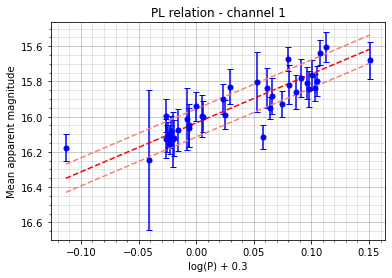

Intercept, a: 16.04
Error in a:    0.01
Std. dev.:     0.08

Distance modulus: 16.44 ± 0.03 (random) ± 0.12 (systematic)
Distance: 19.37 ± 0.29 (random) ± 1.05 (systematic) kpc




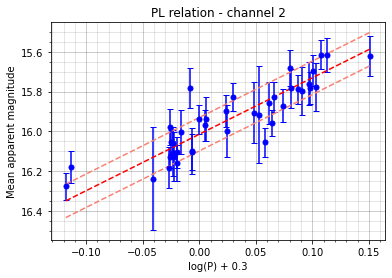

Intercept, a: 16.01
Error in a:    0.01
Std. dev.:     0.08

Distance modulus: 16.42 ± 0.03 (random) ± 0.12 (systematic)
Distance: 19.26 ± 0.29 (random) ± 1.07 (systematic) kpc
No. of ch1 stars: 39
No. of ch2 stars: 40


In [20]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(periods_PL, means_ch1.mask)
periods_ch2 = np.ma.masked_array(periods_PL, means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))

print('No. of ch1 stars:', len(means_ch1.compressed()))
print('No. of ch2 stars:', len(means_ch2.compressed()))

In [13]:
print(means_ch1.argmax())
print(means_ch2.argmax())

print(means_ch1)
print(means_ch2)

39
39
[-- 16.062549046114 16.07514475715958 -- -- -- 15.7801954817224
 16.01436604890409 15.679308001507556 -- 15.761648965163737
 15.928938471000391 -- -- -- 15.837110240504098 -- -- 15.987823548500344
 15.81736728537804 16.10275323071839 16.45552946130165 15.999854031494975
 -- 15.67024307628635 -- 15.99737901538643 -- -- 15.898605252823803 -- --
 -- 16.049486433483978 15.604707889222606 -- 15.859879574307694 --
 15.830914024157257 16.792492801524343 -- -- -- -- 15.880644667004951 --
 16.00928849310882 15.803672489732563 -- 15.951438296780513
 15.819271321621434 -- -- -- -- 15.940986078869626 -- -- --
 16.122376178691418 15.835330861876374 16.126595724252482
 15.806821181066642 16.246031686418394 -- -- -- -- -- 15.79539268398306
 16.114394912989045 16.125572861156783 -- -- -- -- -- -- --
 16.115466633272938 -- -- 16.15673790440372 -- -- -- 16.17668772975797 --
 -- 15.844792548093572 15.635446237264775 16.07975308262815
 16.127293308584097 -- -- -- 15.844499984066124 --]
[-- 16.102004

In [17]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthesebright = []
checkthesedim = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthesebright.append(t_CC['id_new'][i])
    if t_CC['mean_mag_ch1'][i] > 16.4 or t_CC['mean_mag_ch2'][i] > 16.4:
        checkthesedim.append(t_CC['id_new'][i])

print(checkthesebright)
print(checkthesedim)
t_CC.show_in_notebook()

[]
[]


### Plotting PL relation (weighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

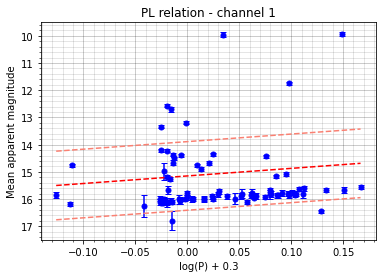

Intercept, a: 15.15
Error in a:    0.15
Std. dev.:     1.26

Distance modulus: 15.55 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.88 ± 0.90 (random) ± 0.70 (systematic) kpc




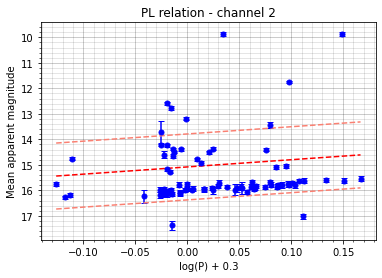

Intercept, a: 15.08
Error in a:    0.15
Std. dev.:     1.29

Distance modulus: 15.49 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.55 ± 0.88 (random) ± 0.70 (systematic) kpc


In [15]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(periods_PL, means_ch1.mask)
periods_ch2 = np.ma.masked_array(periods_PL, means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

#popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed(), sigma=err_mean_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

#popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed(), sigma=err_mean_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))


#### Trying to get matching to master list based on coordinates working (but it won't and i am sad):
These aren't used any more but I'm keeping them around in case I need them

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL2_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
        1 10.402177 34.836456 229.05098 -0.16560569
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1343.18787331), array(75.13551432))


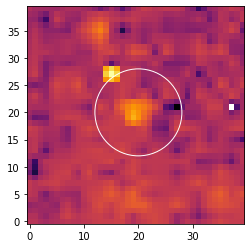

Mean: 55.818267822265625
Median: 53.148773193359375
Std dev: 21.55946159362793
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


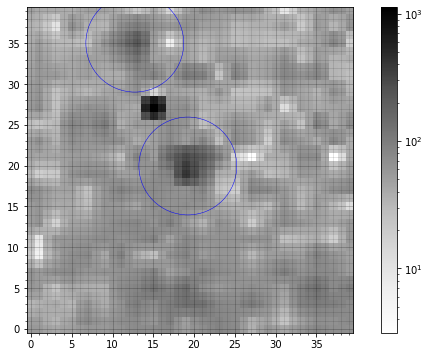

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.227897 19.956908 0.53458902 ... 357.69717 3.6291534  -1.3995133        1
  2 12.724014 35.022011 0.78328236 ... 218.59438 1.6044276 -0.51330033        2


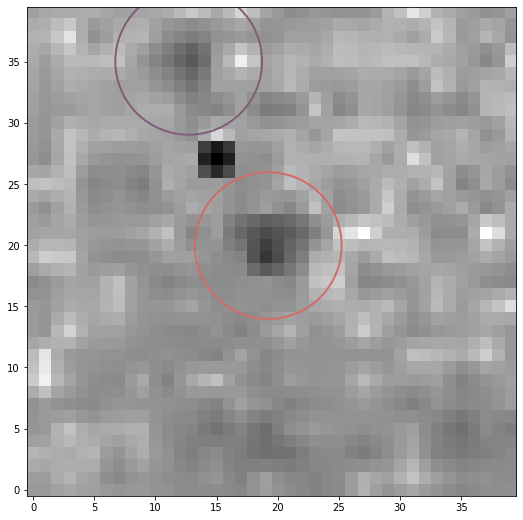

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.10932639999998628s
   x_0       y_0     flux_0   id ...   y_fit    flux_fit  flux_unc iter_detected
--------- --------- -------- --- ... --------- --------- --------- -------------
19.227897 19.956908 4822.526   1 ... 19.956908 4382.3119 123.23011             1
12.724014 35.022011 1350.585   2 ... 35.022011   1767.19 86.806252             1


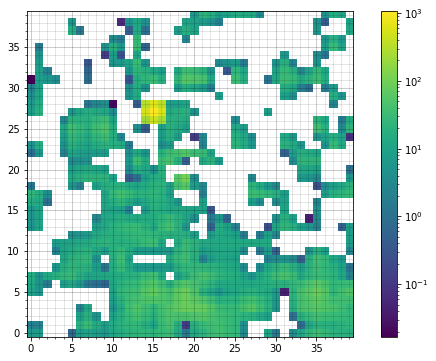

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.227897 19.956908    16.448818 0.042486303
  2        2             1 12.724014 35.022011    17.434868 0.060969787
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 19.227897 19.956908 16.448818 0.042486303
  2 12.724014 35.022011 17.434868 0.060969787
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05319478, -0.16745755), (229.0508948 , -0.16597776)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
       

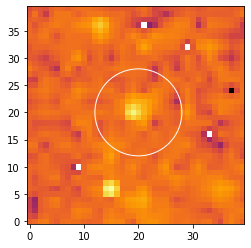

Mean: 48.83451843261719
Median: 46.608665466308594
Std dev: 19.045347213745117
yay all conditions check out
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


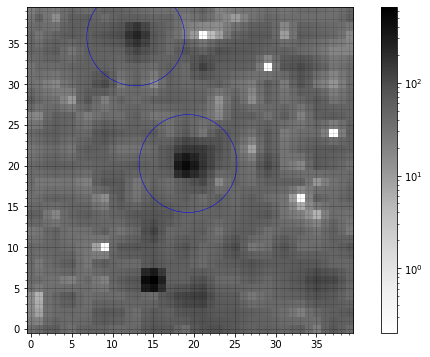

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.255515 20.258677 0.91022835 ... 500.10239 4.4391054  -1.6182387        1
  2 12.842023  35.79453 0.85214092 ... 237.62831 1.9954593 -0.75010718        2


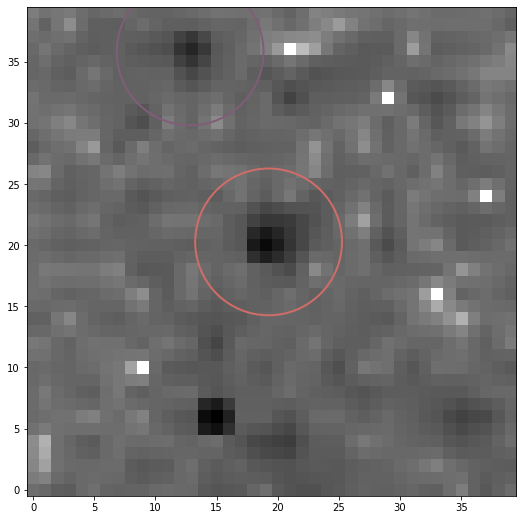

Time taken to fit PSF model: 0.029739500000005137s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.255515 20.258677 4008.3319   1 ... 4498.2229 119.32239             1
12.842023  35.79453  1651.618   2 ...  1964.124 73.524306             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


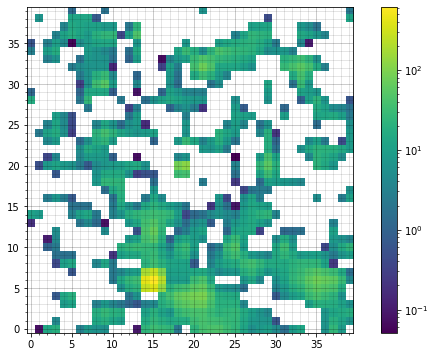

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.255515 20.258677    16.420101 0.041260712
  2        2             1 12.842023  35.79453    17.319781 0.050247543
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 19.255515 20.258677 16.420101 0.041260712
  2 12.842023  35.79453 17.319781 0.050247543
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05314435, -0.16745388), (229.05076385, -0.16597719)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0  17.5

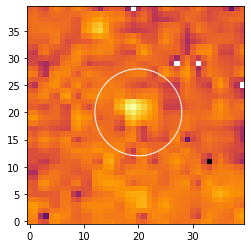

Mean: 47.087528228759766
Median: 44.870487213134766
Std dev: 20.56047248840332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


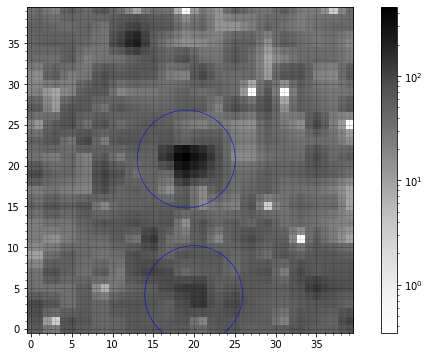

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.938693 4.1834707 0.36345366 ... 118.67358  1.122307 -0.12527918        1
  2 19.050473   20.8107 0.79079518 ... 463.30774 4.1436501  -1.5434577        2


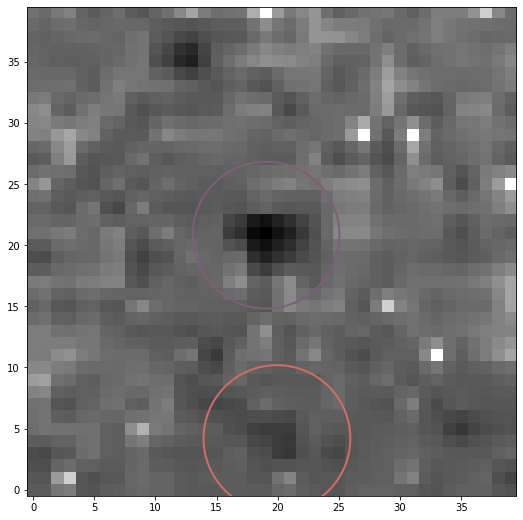

Time taken to fit PSF model: 0.03251090000003387s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.938693 4.1834707 2811.1269   1 ...  1525.146 114.99214             1
19.050473   20.8107 4252.8996   2 ... 4768.3704 126.55147             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


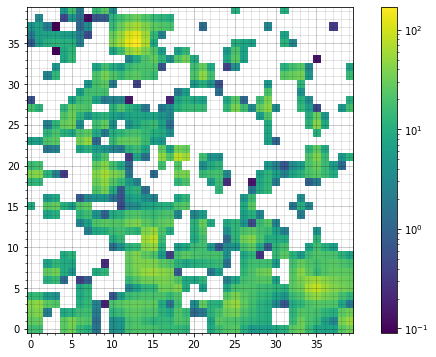

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.938693 4.1834707     17.59489 0.087030485
  2        2             1 19.050473   20.8107    16.357244 0.041270727
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 19.938693 4.1834707  17.59489 0.087030485
  2 19.050473   20.8107 16.357244 0.041270727
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05576938, -0.16800199), (229.05305908, -0.16740521)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
comp @ idx:
[0 0]
id_master   x_0     y_0       RA    ...    err_e1     mag_e2     err_e2  
--------- -------- ------ --------- ... ----------- --------- -----------
        0 17.55

IndexError: index -99 is out of bounds for axis 0 with size 2

In [9]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        star = 2
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')                
                
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            print(cat_match)
            print(cat_m)

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)
            idx2, d2d2, d3d2 = match_coordinates_sky(cat_match, cat_m)
            
            print(idx, d2d, d3d)
            print(idx2, d2d2, d3d2)
            
            print('comp @ idx:')
            print(idx)
            print(comp_table[idx])

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

            print(ind, match_index)

            print('\n\n')
            print_table_nicely(match_table)
            print_table_nicely(comp_table)
            print('\n\n')

            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            
            print(match_table)
            print(comp_table)
            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            match_table = match_table[ind]
            comp_table = comp_table[match_index][ind]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        '''save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()'''


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946
        1  23.78174 2.2946799 228.99106 -0.11590368
        2 19.035947 17.895987 228.98862 -0.11470356
        3 28.339118 3.5178503 228.99074 -0.11662042
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1094.44146707), array(511.14364631))


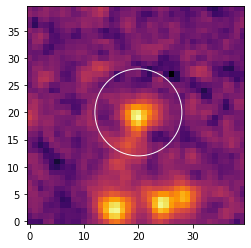

Mean: 51.14960861206055
Median: 45.8643913269043
Std dev: 20.52968978881836
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.575564766899848 ...  3.229357000877366 -1.2727901457891397
  2 24.468016488625913 ... 2.6370181380326754 -1.0527827924589486
  3 19.840980613332604 ... 3.0119700744567304 -1.1971266315018754
Number of PSF stars: 3


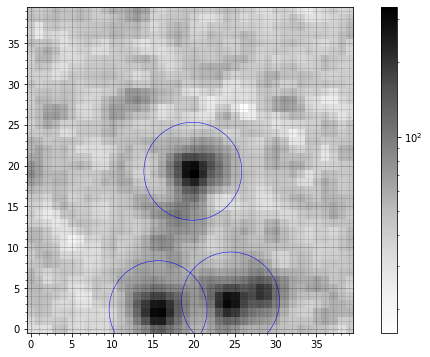

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.575565 2.3412497  0.5500007 ... 313.79651  3.229357 -1.2727901        1
  2 24.468016 3.4122953 0.66038248 ... 308.46622 2.6370181 -1.0527828        1
  3 19.840981 19.312539 0.66081841 ... 335.77524 3.0119701 -1.1971266        2


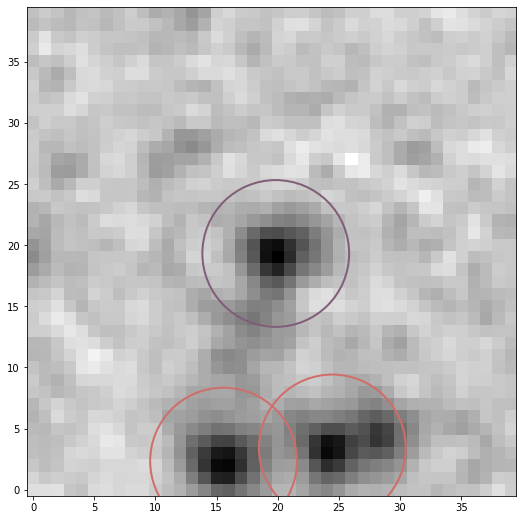

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13006529999984195s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.575565 2.3412497  5234.599   1 ... 4282.3508 158.62785             1
24.468016 3.4122953 6343.6234   2 ... 4203.3857 159.67692             1
19.840981 19.312539 5035.5648   3 ... 4349.1952 97.013214             1
28.818834 4.6227482 1987.8664   4 ... 1950.2446 69.134211             2


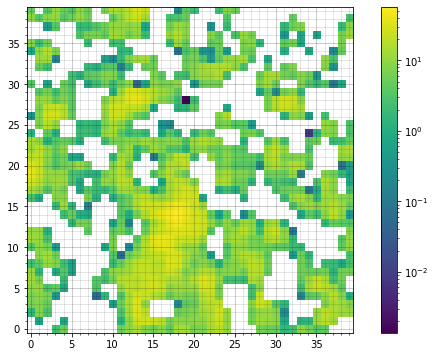

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.575565 2.3412497    16.481396 0.049904437
  2        1             1 24.468016 3.4122953    16.501604 0.050735348
  3        2             1 19.840981 19.312539     16.46458 0.038203282
  4        1             2 28.818834 4.6227482    17.335379 0.048521165
 id  xcenter   ycenter    mag_e1     err_e1   id_master
--- --------- --------- --------- ----------- ---------
  1 15.575565 2.3412497 16.481396 0.049904437         0
  2 24.468016 3.4122953 16.501604 0.050735348         1
  3 19.840981 19.312539  16.46458 0.038203282         2
  4 28.818834 4.6227482 17.335379 0.048521165         3
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946 16.481396 0.049904437
        1 

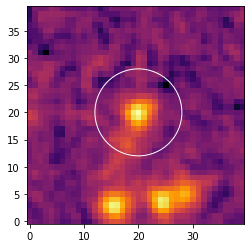

Mean: 45.08599090576172
Median: 39.76604461669922
Std dev: 21.78135871887207
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.529851137079332 ... 2.8684341330745937 -1.1441122044230256
  2 24.588323791199468 ...  2.521756212073415 -1.0042577483475987
  3 19.895611595859556 ... 3.2725228838763614 -1.2872067303461203
Number of PSF stars: 3


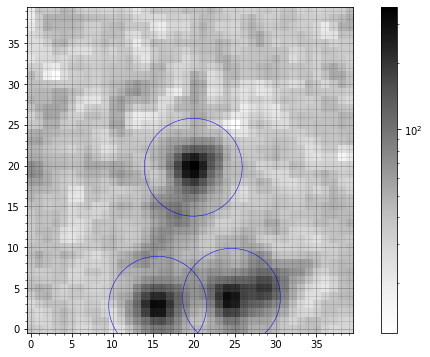

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.529851 2.8852351  0.6115023 ...  317.5033 2.8684341 -1.1441122        1
  2 24.588324 3.8501471 0.64750822 ... 305.72614 2.5217562 -1.0042577        1
  3 19.895612  19.80354 0.63817235 ... 359.59317 3.2725229 -1.2872067        2


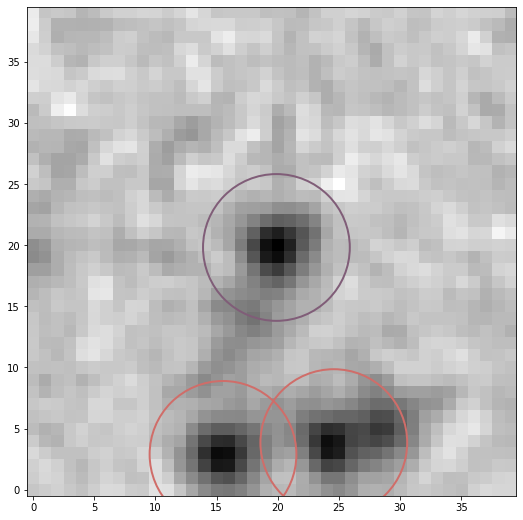

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05155899999954272s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.529851 2.8852351 4907.8212   1 ...  3888.027 149.42427             1
24.588324 3.8501471 6495.5983   2 ... 4029.7415 151.86088             1
19.895612  19.80354 5290.4631   3 ...  4546.161 96.792641             1
28.991484 5.2863925 2094.5302   4 ...  2008.288 91.399826             2


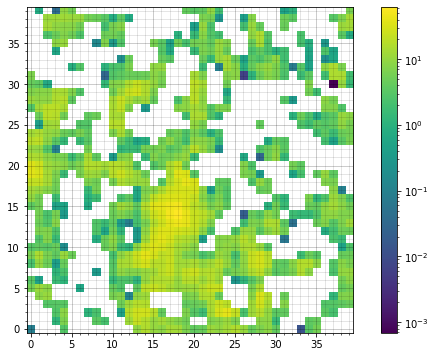

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.529851 2.8852351    16.585697 0.051128195
  2        1             1 24.588324 3.8501471    16.546827  0.05046856
  3        2             1 19.895612  19.80354    16.415908 0.037514391
  4        1             2 28.991484 5.2863925    17.302955 0.057572822
 id  xcenter   ycenter    mag_e2     err_e2   id_master
--- --------- --------- --------- ----------- ---------
  1 15.529851 2.8852351 16.585697 0.051128195         0
  2 24.588324 3.8501471 16.546827  0.05046856         1
  3 19.895612  19.80354 16.415908 0.037514391         2
  4 28.991484 5.2863925 17.302955 0.057572822         3
id_master    x_0       y_0        RA    ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049904437 16.585697 0.05112819

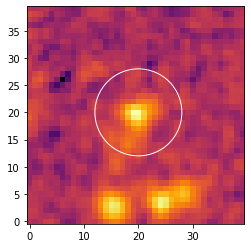

Mean: 43.298133850097656
Median: 38.060081481933594
Std dev: 21.694374084472656
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.324348926937843 ...  2.740425138283709  -1.094544856766432
  2 24.356835138718903 ...  2.714869883759798 -1.0843725497115577
  3  19.62447740837231 ... 3.2168555396751186 -1.2685788958587219
Number of PSF stars: 3


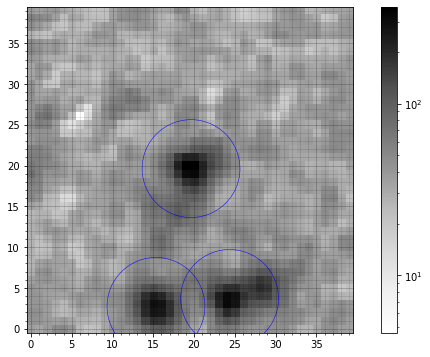

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.324349 2.7371235  0.5340575 ... 289.66589 2.7404251 -1.0945449        1
  2 24.356835 3.7104366 0.65278165 ... 315.94113 2.7148699 -1.0843725        1
  3 19.624477  19.63687  0.6275326 ... 355.89859 3.2168555 -1.2685789        2


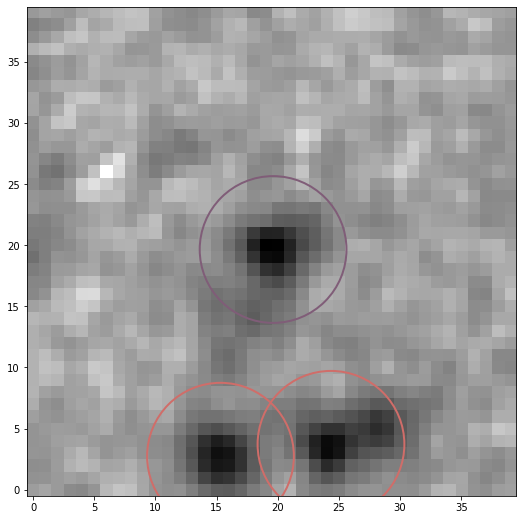

Time taken to fit PSF model: 0.05036079999990761s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.324349 2.7371235 4992.7411   1 ... 4055.7058 150.07603             1
24.356835 3.7104366  6316.759   2 ... 4313.4969 150.60356             1
19.624477  19.63687 5878.2963   3 ... 4946.7007 89.934214             1
28.912678 5.2484861 2236.2822   4 ... 2001.7659 81.189482             2


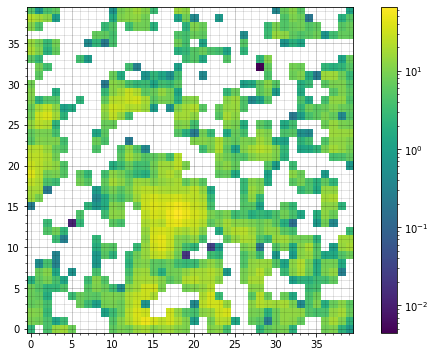

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.324349 2.7371235    16.540501 0.049870705
  2        1             1 24.356835 3.7104366    16.473594 0.048062134
  3        2             1 19.624477  19.63687    16.324878 0.035533096
  4        1             2 28.912678 5.2484861    17.307134 0.053029737
 id  xcenter   ycenter    mag_e3     err_e3   id_master
--- --------- --------- --------- ----------- ---------
  1 15.324349 2.7371235 16.540501 0.049870705         0
  2 24.356835 3.7104366 16.473594 0.048062134         1
  3 19.624477  19.63687 16.324878 0.035533096         2
  4 28.912678 5.2484861 17.307134 0.053029737         3
id_master    x_0       y_0        RA    ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.051128195 16.540501 0.04987070

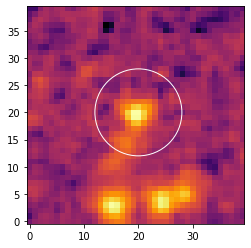

Mean: 41.48185729980469
Median: 36.60084533691406
Std dev: 21.256439208984375
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.402103064215103 ...  2.940967477508381 -1.1712255547930523
  2 24.441040130497164 ... 2.5445886987166184 -1.0140439850382048
  3 19.584984056330125 ...  3.317834368858013 -1.3021367540351565
Number of PSF stars: 3


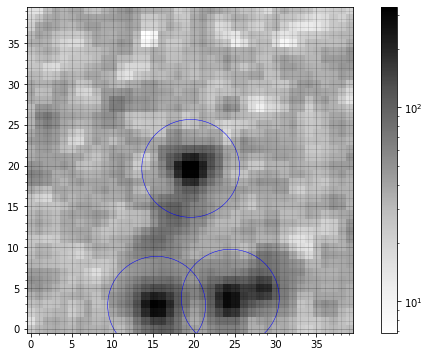

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.402103 2.8725598 0.62275623 ... 325.81424 2.9409675 -1.1712256        1
  2  24.44104 3.7414083 0.61550877 ... 291.70139 2.5445887  -1.014044        1
  3 19.584984 19.661793 0.57186691 ... 331.10718 3.3178344 -1.3021368        2


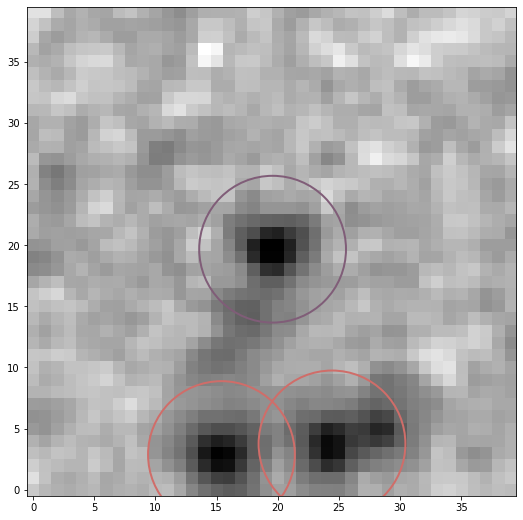

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13611569999920903s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.402103 2.8725598 5329.7702   1 ... 4051.8584 141.20479             1
 24.44104 3.7414083 6082.0895   2 ... 4012.1419 146.73186             1
19.584984 19.661793 5237.4321   3 ... 4606.1036 84.637918             1
28.863052 5.1782517 1945.5198   4 ... 1840.7738  83.87635             2


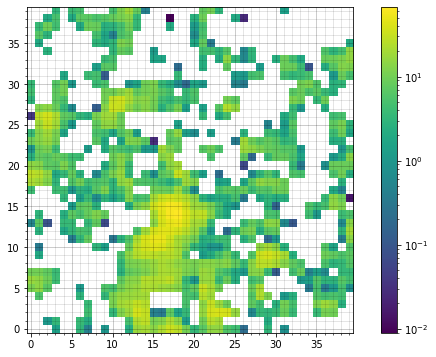

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.402103 2.8725598    16.541081 0.048006401
  2        1             1  24.44104 3.7414083    16.551776 0.049493862
  3        2             1 19.584984 19.661793    16.401882 0.035650853
  4        1             2 28.863052 5.1782517    17.397715 0.057623613
 id  xcenter   ycenter    mag_e4     err_e4   id_master
--- --------- --------- --------- ----------- ---------
  1 15.402103 2.8725598 16.541081 0.048006401         0
  2  24.44104 3.7414083 16.551776 0.049493862         1
  3 19.584984 19.661793 16.401882 0.035650853         2
  4 28.863052 5.1782517 17.397715 0.057623613         3
id_master    x_0       y_0        RA    ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049870705 16.541081 0.04800640

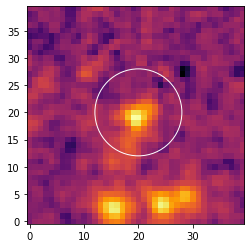

Mean: 41.5771484375
Median: 36.40973663330078
Std dev: 20.748353958129883
 id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 15.41594560840494 ... 3.177380045210075  -1.2551729093265562
  2 24.46245075408594 ... 2.722809928717321   -1.087543313972069
  3 28.03162586417031 ... 1.344736198500567 -0.32159273915026876
  4 19.64046228737398 ... 3.441693502329084  -1.3419304797856226
Number of PSF stars: 4


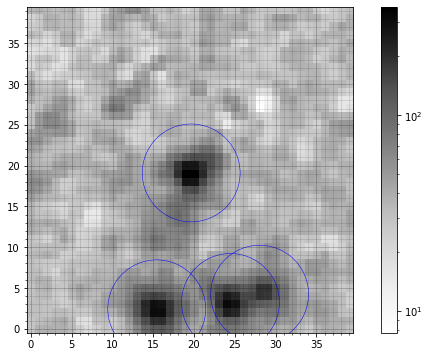

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.415946 2.4431413 0.54827609 ...  302.9071   3.17738  -1.2551729        1
  2 24.462451 3.2251417 0.69369881 ... 313.86978 2.7228099  -1.0875433        1
  3 28.031626 4.2359861 0.67056078 ... 186.96165 1.3447362 -0.32159274        1
  4 19.640462 19.105593  0.6297486 ... 353.34238 3.4416935  -1.3419305        2


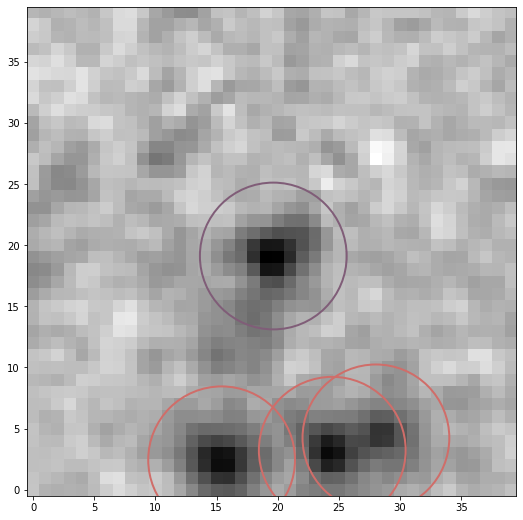

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04051690000051167s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.415946 2.4431413 5087.0391   1 ... 4361.4582 93.197894             1
24.462451 3.2251417 6117.9363   2 ... 3480.1308 89.643748             1
28.031626 4.2359861 5933.2528   3 ... 1937.2708 95.931724             1
19.640462 19.105593 5364.6779   4 ... 4337.1694 89.390413             1


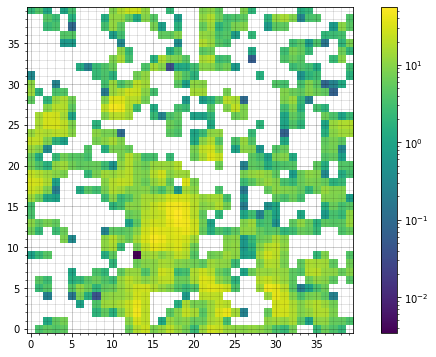

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.415946 2.4431413    16.461172 0.037566263
  2        1             1 24.462451 3.2251417    16.706262 0.040683178
  3        1             1 28.031626 4.2359861    17.342275 0.061348083
  4        2             1 19.640462 19.105593    16.467235 0.037063511
 id  xcenter   ycenter    mag_e5     err_e5   id_master
--- --------- --------- --------- ----------- ---------
  1 15.415946 2.4431413 16.461172 0.037566263         0
  2 24.462451 3.2251417 16.706262 0.040683178         1
  3 28.031626 4.2359861 17.342275 0.061348083         2
  4 19.640462 19.105593 16.467235 0.037063511         3
id_master    x_0       y_0        RA    ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.048006401 16.461172 0.03756626

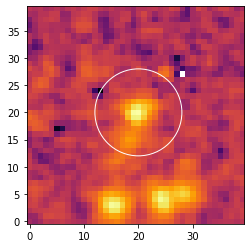

Mean: 34.465213775634766
Median: 28.9788818359375
Std dev: 21.482254028320312
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.434755562019973 ...  2.738553859224638 -1.0938032165799807
  2 24.534598456523725 ... 2.4849501718563496 -0.9882942117430025
  3  19.74102929173598 ... 3.1529990801217895 -1.2468096101094626
Number of PSF stars: 3


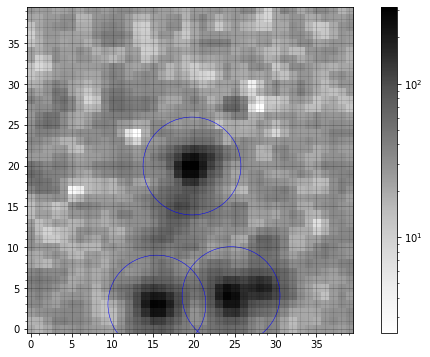

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.434756 3.0174515 0.61955722 ... 295.59125 2.7385539  -1.0938032        1
  2 24.534598 4.0607341 0.64556602 ... 289.43369 2.4849502 -0.98829421        1
  3 19.741029 19.956366 0.59445665 ... 317.62701 3.1529991  -1.2468096        2


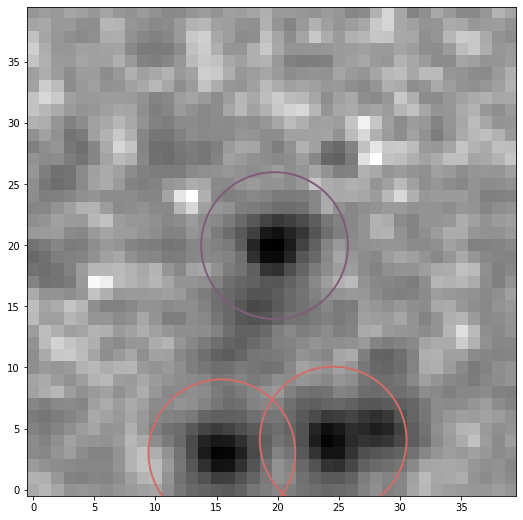

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.053249399999913294s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.434756 3.0174515 4753.6891   1 ... 3652.2488 138.09474             1
24.534598 4.0607341 6293.5869   2 ... 3843.2674 138.94848             1
19.741029 19.956366 5310.5515   3 ... 4089.3208 104.98822             1
28.973933 5.1364362 2135.1223   4 ...  1802.625 89.064865             2


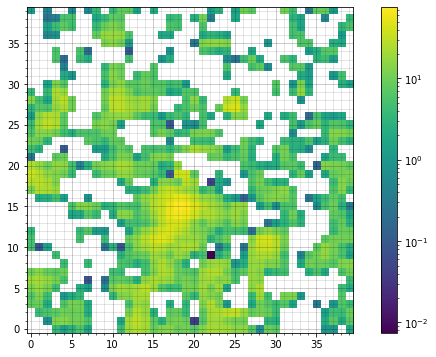

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.434756 3.0174515    16.653923 0.050579411
  2        1             1 24.534598 4.0607341    16.598573 0.049130323
  3        2             1 19.741029 19.956366    16.531196  0.04061981
  4        1             2 28.973933 5.1364362    17.420561 0.061242892
 id  xcenter   ycenter    mag_e6     err_e6   id_master
--- --------- --------- --------- ----------- ---------
  1 15.434756 3.0174515 16.653923 0.050579411         0
  2 24.534598 4.0607341 16.598573 0.049130323         1
  3 19.741029 19.956366 16.531196  0.04061981         2
  4 28.973933 5.1364362 17.420561 0.061242892         3
id_master    x_0       y_0        RA    ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.037566263 16.653923 0.05057941

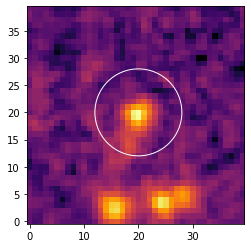

Mean: 44.564720153808594
Median: 39.59773254394531
Std dev: 20.280550003051758
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.564749020605866 ... 2.9685813322824215 -1.1813723802308034
  2 24.521924645846568 ...  2.701261719771453 -1.0789166603446532
  3    19.834005774293 ...  3.475327996429202 -1.3524894973636068
Number of PSF stars: 3


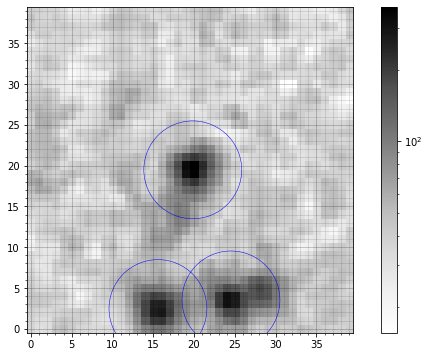

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.564749 2.4744354  0.5221548 ... 280.71216 2.9685813 -1.1813724        1
  2 24.521925 3.5346052 0.66508775 ... 305.35577 2.7012617 -1.0789167        1
  3 19.834006 19.485999 0.67392894 ... 367.90244  3.475328 -1.3524895        2


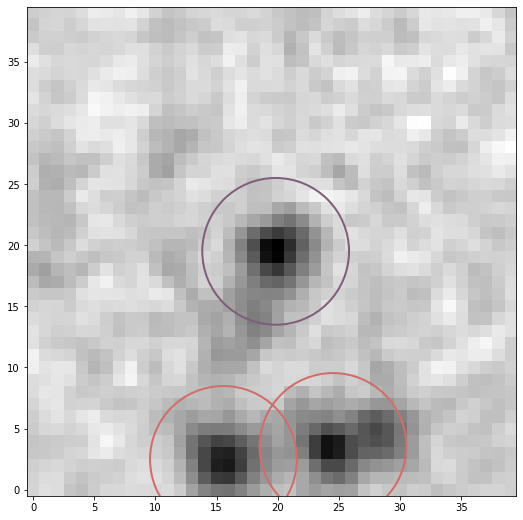

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.11658429999806685s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.564749 2.4744354 4970.8549   1 ... 4167.3416 152.34688             1
24.521925 3.5346052 6218.9892   2 ... 4314.5054 151.11573             1
19.834006 19.485999 5261.3001   3 ... 4973.3311  114.0385             1
28.882514  4.655196 1819.9378   4 ... 1733.0658 75.841961             2


KeyboardInterrupt: 

In [145]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')

        print_table_nicely(master_table)

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi=1.)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                    
                print(sources_PSF)
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                for i, group in enumerate(star_groups.groups):
                    pos_group = np.transpose([group['x_0'], group['y_0']])
                    ap_group = CircularAperture(pos_group, r_ap)
                    ap_group.plot(color=cmap.colors[i], lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                match_table['id_master'] = master_table['id_master']

                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###


            # This approach relies on the same stars being detected in the same order in each epoch, which isn't ideal:
            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)


            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close() 


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###